In [ ]:
import os
import time
import copy
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import timm
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import matplotlib.pyplot as plt

# R-Drop loss calculation
def compute_kl_loss(p, q):
    p_log_prob = F.log_softmax(p, dim=-1)
    q_log_prob = F.log_softmax(q, dim=-1)
    p_prob = F.softmax(p, dim=-1)
    q_prob = F.softmax(q, dim=-1)
    kl_pq = F.kl_div(p_log_prob, q_prob, reduction='batchmean')
    kl_qp = F.kl_div(q_log_prob, p_prob, reduction='batchmean')
    return (kl_pq + kl_qp) / 2

def rdrop_loss(output1, output2, target, alpha=1.0):
    ce_loss = 0.5 * (F.cross_entropy(output1, target) + F.cross_entropy(output2, target))
    kl_loss = compute_kl_loss(output1, output2)
    return ce_loss + alpha * kl_loss

# Dataset and model loading
def get_data_loaders(dataset_name):
    if dataset_name in ['CIFAR10', 'CIFAR100']:
        transform_train = transforms.Compose([
            transforms.Resize(image_size[dataset_name]),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(image_size[dataset_name], padding=4),
            transforms.ToTensor(),
            transforms.Normalize(normalization_params[dataset_name]['mean'],
                                 normalization_params[dataset_name]['std']),
        ])

        transform_val = transforms.Compose([
            transforms.Resize(image_size[dataset_name]),
            transforms.ToTensor(),
            transforms.Normalize(normalization_params[dataset_name]['mean'],
                                 normalization_params[dataset_name]['std']),
        ])

        if dataset_name == 'CIFAR10':
            train_dataset = torchvision.datasets.CIFAR10(root=data_dir[dataset_name],
                                                         train=True,
                                                         download=True,
                                                         transform=transform_train)
            val_dataset = torchvision.datasets.CIFAR10(root=data_dir[dataset_name],
                                                       train=False,
                                                       download=True,
                                                       transform=transform_val)
        else:
            train_dataset = torchvision.datasets.CIFAR100(root=data_dir[dataset_name],
                                                          train=True,
                                                          download=True,
                                                          transform=transform_train)
            val_dataset = torchvision.datasets.CIFAR100(root=data_dir[dataset_name],
                                                        train=False,
                                                        download=True,
                                                        transform=transform_val)
    elif dataset_name == 'ImageNet':
        transform_train = transforms.Compose([
            transforms.Resize(image_size[dataset_name]),
            transforms.RandomResizedCrop(image_size[dataset_name]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(normalization_params[dataset_name]['mean'],
                                 normalization_params[dataset_name]['std']),
        ])

        transform_val = transforms.Compose([
            transforms.Resize(image_size[dataset_name]),
            transforms.CenterCrop(image_size[dataset_name]),
            transforms.ToTensor(),
            transforms.Normalize(normalization_params[dataset_name]['mean'],
                                 normalization_params[dataset_name]['std']),
        ])

        train_dataset = torchvision.datasets.ImageNet(root=data_dir[dataset_name],
                                                      split='train',
                                                      download=False,
                                                      transform=transform_train)
        val_dataset = torchvision.datasets.ImageNet(root=data_dir[dataset_name],
                                                    split='val',
                                                    download=False,
                                                    transform=transform_val)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False,
                            num_workers=4, pin_memory=True)

    return train_loader, val_loader

def get_model(model_name, num_classes, dataset_name):
    if model_name.startswith('vit'):
        model = timm.create_model(model_name, pretrained=True)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    elif model_name == 'vgg16':
        model = torchvision.models.vgg16(pretrained=True)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
    elif model_name == 'resnet50':
        model = torchvision.models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

# Training and Evaluation Functions
def train_epoch_standard(model, optimizer, criterion, train_loader, epoch, dataset_name, model_name, scaler=None, gradient_accumulation_steps=16):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch} [Standard Training] ({dataset_name}, {model_name})")

    for step, (images, targets) in enumerate(epoch_iterator):
        images = images.to(device)
        targets = targets.to(device)

        with autocast(enabled=scaler is not None):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / gradient_accumulation_steps

        if scaler:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            if scaler:
                scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if scaler:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * gradient_accumulation_steps * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def train_epoch_rdrop(model, optimizer, alpha, train_loader, epoch, dataset_name, model_name, scaler=None, gradient_accumulation_steps=16):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    epoch_iterator = tqdm(train_loader, desc=f"Epoch {epoch} [R-Drop Training] ({dataset_name}, {model_name})")

    for step, (images, targets) in enumerate(epoch_iterator):
        images = images.to(device)
        targets = targets.to(device)

        with autocast(enabled=scaler is not None):
            outputs1 = model(images)
            outputs2 = model(images)
            loss = rdrop_loss(outputs1, outputs2, targets, alpha)
            loss = loss / gradient_accumulation_steps

        if scaler:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            if scaler:
                scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if scaler:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * gradient_accumulation_steps * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate(model, criterion, val_loader, dataset_name, model_name):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Evaluating ({dataset_name}, {model_name})"):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

# Scheduler
def get_cosine_schedule_with_warmup(optimizer, num_warmup_epochs, num_training_epochs):
    def lr_lambda(current_epoch):
        if current_epoch < num_warmup_epochs:
            return float(current_epoch) / float(max(1, num_warmup_epochs))
        progress = float((current_epoch - num_warmup_epochs)) / float(max(1, num_training_epochs - num_warmup_epochs))
        return max(0.0, 0.5 * (1. + math.cos(math.pi * progress)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Training and evaluation pipeline
def train_and_evaluate(dataset_name, model_name, rdrop_flag, early_stopping_patience=-1):
    print(f"\n=== Training {model_name} on {dataset_name} with R-Drop = {rdrop_flag} ===")

    train_loader, val_loader = get_data_loaders(dataset_name)

    n_classes = num_classes[dataset_name]

    model = get_model(model_name, n_classes, dataset_name)
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=base_lr[dataset_name], momentum=0.9, weight_decay=weight_decay)
    # optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scaler = GradScaler()

    scheduler = get_cosine_schedule_with_warmup(optimizer, 500, num_epochs_dict[dataset_name])

    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early stopping
    epochs_no_improve = 0
    best_val_loss = float('inf')

    for epoch in range(1, num_epochs_dict[dataset_name] + 1):
        start_time = time.time()

        if rdrop_flag:
            train_loss = train_epoch_rdrop(model, optimizer, alpha, train_loader, epoch, dataset_name, model_name, scaler)
        else:
            train_loss = train_epoch_standard(model, optimizer, criterion, train_loader, epoch, dataset_name, model_name, scaler)

        val_loss, val_acc = evaluate(model, criterion, val_loader, dataset_name, model_name)

        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            save_path = f'best_model_{model_name}_{dataset_name}_{"RDrop" if rdrop_flag else "Standard"}.pth'
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with accuracy: {best_acc:.2f}%")

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch}/{num_epochs_dict[dataset_name]}] "
              f"Train Loss: {train_loss:.4f} "
              f"Val Loss: {val_loss:.4f} "
              f"Val Acc: {val_acc:.2f}% "
              f"Time: {epoch_time:.2f}s")

        # For early stopping
        if val_loss <= best_val_loss:
          best_val_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1
          if epochs_no_improve == early_stopping_patience:
              print("Early stopping triggered.")
              break

    print(f"Training completed for {model_name} on {dataset_name} with R-Drop = {rdrop_flag}")
    print(f"Best Validation Accuracy: {best_acc:.2f}%\n")

    model.load_state_dict(best_model_wts)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_accuracy': best_acc
    }

# Plotting results
def plot_results(metrics):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['val_accuracies'], label='Validation Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_losses'], label='Training Loss', color='orange')
    plt.plot(metrics['val_losses'], label='Validation Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Configuration and Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

# Hyperparameters
train_batch_size = 256 # # ViT default: 512
eval_batch_size = 64
# learning_rate = 3e-3  # For training models from scratch (not used)
weight_decay = 0.0 # Try 0.0001 for CNNs
alpha = 0.6  # R-Drop coefficient (R-Drop default 0.6, try 0.9 for CNNs)

datasets = ['CIFAR10', 'CIFAR100', 'ImageNet']
models = ['vit_base_patch16_224', 'vit_large_patch16_224', 'vgg16', 'resnet50']

num_classes = {
    'CIFAR10': 10,
    'CIFAR100': 100,
    'ImageNet': 1000
}

image_size = {
    'CIFAR10': 224,
    'CIFAR100': 224,
    'ImageNet': 384
}

# For fine tuning
base_lr = {
    'CIFAR10': 0.01,
    'CIFAR100': 0.01,
    'ImageNet': 0.03
}

# Number of epochs per dataset, change as needed
num_epochs_dict = {
    'CIFAR10': 60, 
    'CIFAR100': 90,  
    'ImageNet': 8 
}

# Normalization parameters
normalization_params = {
    'CIFAR10': {
        'mean': [0.4914, 0.4822, 0.4465],
        'std': [0.2023, 0.1994, 0.2010]
    },
    'CIFAR100': {
        'mean': [0.5071, 0.4867, 0.4408],
        'std': [0.2675, 0.2565, 0.2761]
    },
    'ImageNet': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    }
}

data_dir = {
    'CIFAR10': './data/CIFAR10',
    'CIFAR100': './data/CIFAR100',
    'ImageNet': './data/ImageNet'
}

for ds in datasets:
    os.makedirs(os.path.join(data_dir[ds], 'train'), exist_ok=True)
    os.makedirs(os.path.join(data_dir[ds], 'val'), exist_ok=True)

Using device: cuda


Training ViT-B/16 on CIFAR-10 with R-Drop


=== Training vit_base_patch16_224 on CIFAR10 with R-Drop = True ===
Files already downloaded and verified
Files already downloaded and verified


<ipython-input-4-b7781719b6be>:307: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [R-Drop Training] (CIFAR10, vit_base_patch16_224):   0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-4-b7781719b6be>:235: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Epoch 1 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:34<00:00,  2.08it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.19it/s]


Best model saved with accuracy: 15.13%
Epoch [1/60] Train Loss: 2.6817 Val Loss: 2.7004 Val Acc: 15.13% Time: 116.39s


Epoch 2 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 15.39%
Epoch [2/60] Train Loss: 2.6675 Val Loss: 2.6681 Val Acc: 15.39% Time: 114.60s


Epoch 3 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 15.83%
Epoch [3/60] Train Loss: 2.6199 Val Loss: 2.5999 Val Acc: 15.83% Time: 114.48s


Epoch 4 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 16.68%
Epoch [4/60] Train Loss: 2.5420 Val Loss: 2.5075 Val Acc: 16.68% Time: 114.55s


Epoch 5 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 18.24%
Epoch [5/60] Train Loss: 2.4447 Val Loss: 2.4017 Val Acc: 18.24% Time: 114.13s


Epoch 6 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 20.31%
Epoch [6/60] Train Loss: 2.3371 Val Loss: 2.2855 Val Acc: 20.31% Time: 114.49s


Epoch 7 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 23.81%
Epoch [7/60] Train Loss: 2.2215 Val Loss: 2.1610 Val Acc: 23.81% Time: 114.38s


Epoch 8 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 29.56%
Epoch [8/60] Train Loss: 2.0955 Val Loss: 2.0287 Val Acc: 29.56% Time: 114.59s


Epoch 9 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 36.89%
Epoch [9/60] Train Loss: 1.9579 Val Loss: 1.8843 Val Acc: 36.89% Time: 114.49s


Epoch 10 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 46.69%
Epoch [10/60] Train Loss: 1.8078 Val Loss: 1.7266 Val Acc: 46.69% Time: 114.51s


Epoch 11 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 56.82%
Epoch [11/60] Train Loss: 1.6422 Val Loss: 1.5539 Val Acc: 56.82% Time: 114.67s


Epoch 12 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 65.93%
Epoch [12/60] Train Loss: 1.4622 Val Loss: 1.3676 Val Acc: 65.93% Time: 114.48s


Epoch 13 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 74.09%
Epoch [13/60] Train Loss: 1.2695 Val Loss: 1.1704 Val Acc: 74.09% Time: 114.63s


Epoch 14 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 80.58%
Epoch [14/60] Train Loss: 1.0676 Val Loss: 0.9685 Val Acc: 80.58% Time: 114.69s


Epoch 15 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 85.19%
Epoch [15/60] Train Loss: 0.8666 Val Loss: 0.7706 Val Acc: 85.19% Time: 114.36s


Epoch 16 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 88.73%
Epoch [16/60] Train Loss: 0.6774 Val Loss: 0.5910 Val Acc: 88.73% Time: 114.39s


Epoch 17 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 91.11%
Epoch [17/60] Train Loss: 0.5113 Val Loss: 0.4401 Val Acc: 91.11% Time: 114.43s


Epoch 18 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 93.12%
Epoch [18/60] Train Loss: 0.3754 Val Loss: 0.3215 Val Acc: 93.12% Time: 114.72s


Epoch 19 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 94.57%
Epoch [19/60] Train Loss: 0.2723 Val Loss: 0.2351 Val Acc: 94.57% Time: 114.59s


Epoch 20 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 95.84%
Epoch [20/60] Train Loss: 0.1995 Val Loss: 0.1756 Val Acc: 95.84% Time: 114.33s


Epoch 21 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 96.58%
Epoch [21/60] Train Loss: 0.1493 Val Loss: 0.1377 Val Acc: 96.58% Time: 114.53s


Epoch 22 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 97.17%
Epoch [22/60] Train Loss: 0.1168 Val Loss: 0.1132 Val Acc: 97.17% Time: 114.35s


Epoch 23 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 97.39%
Epoch [23/60] Train Loss: 0.0961 Val Loss: 0.0985 Val Acc: 97.39% Time: 114.34s


Epoch 24 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 97.60%
Epoch [24/60] Train Loss: 0.0816 Val Loss: 0.0879 Val Acc: 97.60% Time: 114.23s


Epoch 25 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 97.84%
Epoch [25/60] Train Loss: 0.0715 Val Loss: 0.0810 Val Acc: 97.84% Time: 114.11s


Epoch 26 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 97.94%
Epoch [26/60] Train Loss: 0.0648 Val Loss: 0.0752 Val Acc: 97.94% Time: 114.32s


Epoch 27 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 98.01%
Epoch [27/60] Train Loss: 0.0581 Val Loss: 0.0714 Val Acc: 98.01% Time: 114.36s


Epoch 28 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 98.12%
Epoch [28/60] Train Loss: 0.0534 Val Loss: 0.0685 Val Acc: 98.12% Time: 114.30s


Epoch 29 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 98.22%
Epoch [29/60] Train Loss: 0.0492 Val Loss: 0.0661 Val Acc: 98.22% Time: 114.31s


Epoch 30 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.29%
Epoch [30/60] Train Loss: 0.0452 Val Loss: 0.0635 Val Acc: 98.29% Time: 113.98s


Epoch 31 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [31/60] Train Loss: 0.0426 Val Loss: 0.0614 Val Acc: 98.26% Time: 113.44s


Epoch 32 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [32/60] Train Loss: 0.0387 Val Loss: 0.0607 Val Acc: 98.28% Time: 113.17s


Epoch 33 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.34%
Epoch [33/60] Train Loss: 0.0364 Val Loss: 0.0595 Val Acc: 98.34% Time: 113.97s


Epoch 34 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 98.39%
Epoch [34/60] Train Loss: 0.0338 Val Loss: 0.0574 Val Acc: 98.39% Time: 114.29s


Epoch 35 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [35/60] Train Loss: 0.0320 Val Loss: 0.0573 Val Acc: 98.33% Time: 113.38s


Epoch 36 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [36/60] Train Loss: 0.0295 Val Loss: 0.0555 Val Acc: 98.39% Time: 113.56s


Epoch 37 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 98.43%
Epoch [37/60] Train Loss: 0.0279 Val Loss: 0.0554 Val Acc: 98.43% Time: 114.21s


Epoch 38 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.47%
Epoch [38/60] Train Loss: 0.0262 Val Loss: 0.0543 Val Acc: 98.47% Time: 113.96s


Epoch 39 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.48%
Epoch [39/60] Train Loss: 0.0240 Val Loss: 0.0544 Val Acc: 98.48% Time: 114.05s


Epoch 40 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [40/60] Train Loss: 0.0220 Val Loss: 0.0537 Val Acc: 98.47% Time: 113.33s


Epoch 41 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 98.50%
Epoch [41/60] Train Loss: 0.0204 Val Loss: 0.0537 Val Acc: 98.50% Time: 114.08s


Epoch 42 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 98.52%
Epoch [42/60] Train Loss: 0.0200 Val Loss: 0.0529 Val Acc: 98.52% Time: 114.03s


Epoch 43 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 98.54%
Epoch [43/60] Train Loss: 0.0179 Val Loss: 0.0524 Val Acc: 98.54% Time: 113.95s


Epoch 44 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [44/60] Train Loss: 0.0167 Val Loss: 0.0527 Val Acc: 98.48% Time: 113.25s


Epoch 45 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [45/60] Train Loss: 0.0160 Val Loss: 0.0517 Val Acc: 98.53% Time: 113.37s


Epoch 46 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [46/60] Train Loss: 0.0151 Val Loss: 0.0520 Val Acc: 98.51% Time: 113.23s


Epoch 47 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [47/60] Train Loss: 0.0137 Val Loss: 0.0517 Val Acc: 98.51% Time: 113.42s


Epoch 48 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [48/60] Train Loss: 0.0124 Val Loss: 0.0512 Val Acc: 98.51% Time: 113.34s


Epoch 49 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [49/60] Train Loss: 0.0114 Val Loss: 0.0523 Val Acc: 98.53% Time: 113.23s


Epoch 50 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.58%
Epoch [50/60] Train Loss: 0.0107 Val Loss: 0.0510 Val Acc: 98.58% Time: 114.00s


Epoch 51 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [51/60] Train Loss: 0.0103 Val Loss: 0.0522 Val Acc: 98.58% Time: 113.29s


Epoch 52 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [52/60] Train Loss: 0.0092 Val Loss: 0.0518 Val Acc: 98.55% Time: 113.14s


Epoch 53 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 98.60%
Epoch [53/60] Train Loss: 0.0086 Val Loss: 0.0518 Val Acc: 98.60% Time: 114.01s


Epoch 54 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [54/60] Train Loss: 0.0081 Val Loss: 0.0528 Val Acc: 98.56% Time: 113.27s


Epoch 55 [R-Drop Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.14it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [55/60] Train Loss: 0.0073 Val Loss: 0.0537 Val Acc: 98.56% Time: 113.04s
Early stopping triggered.
Training completed for vit_base_patch16_224 on CIFAR10 with R-Drop = True
Best Validation Accuracy: 98.60%



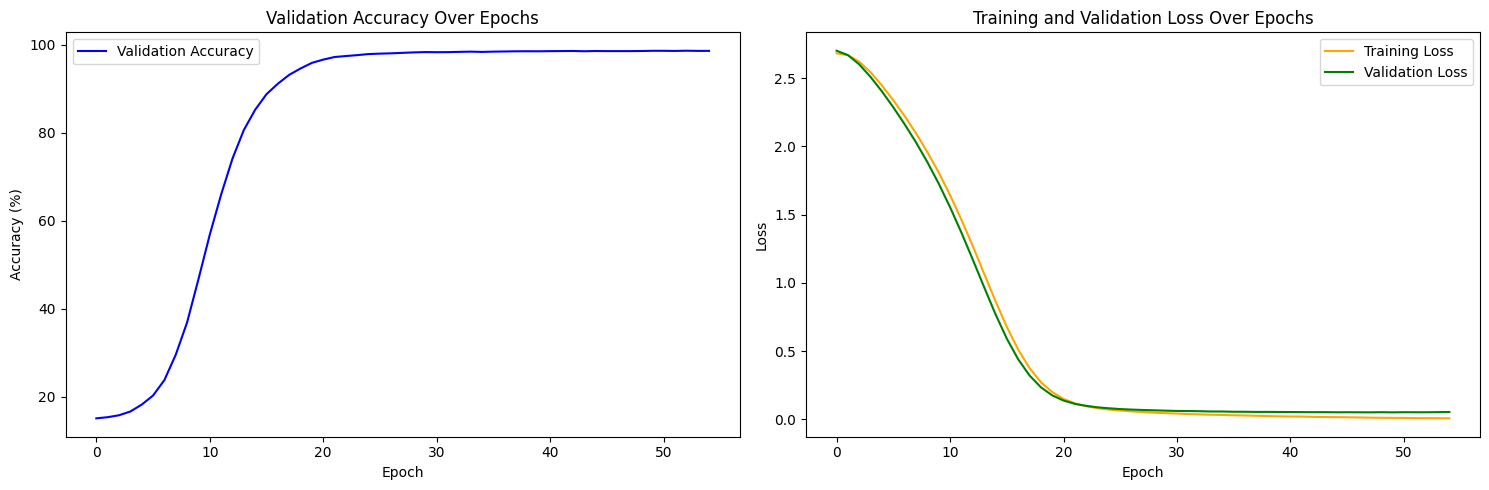

In [ ]:
metrics_C10_ViTB_RDrop = train_and_evaluate('CIFAR10', 'vit_base_patch16_224', True, 5)
plot_results(metrics_C10_ViTB_RDrop)

Training ViT-B/16 on CIFAR-10


=== Training vit_base_patch16_224 on CIFAR10 with R-Drop = False ===


100%|██████████| 170M/170M [00:02<00:00, 58.8MB/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-1-0129c0f41d9d>:307: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [Standard Training] (CIFAR10, vit_base_patch16_224):   0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-1-0129c0f41d9d>:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Epoch 1 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:51<00:00,  3.81it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 15.13%
Epoch [1/55] Train Loss: 2.6817 Val Loss: 2.7004 Val Acc: 15.13% Time: 73.62s


Epoch 2 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 15.39%
Epoch [2/55] Train Loss: 2.6675 Val Loss: 2.6681 Val Acc: 15.39% Time: 71.22s


Epoch 3 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 15.83%
Epoch [3/55] Train Loss: 2.6199 Val Loss: 2.5999 Val Acc: 15.83% Time: 71.20s


Epoch 4 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 16.67%
Epoch [4/55] Train Loss: 2.5420 Val Loss: 2.5075 Val Acc: 16.67% Time: 71.27s


Epoch 5 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.29it/s]


Best model saved with accuracy: 18.26%
Epoch [5/55] Train Loss: 2.4447 Val Loss: 2.4018 Val Acc: 18.26% Time: 71.13s


Epoch 6 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 20.31%
Epoch [6/55] Train Loss: 2.3372 Val Loss: 2.2855 Val Acc: 20.31% Time: 71.25s


Epoch 7 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 23.79%
Epoch [7/55] Train Loss: 2.2214 Val Loss: 2.1609 Val Acc: 23.79% Time: 71.22s


Epoch 8 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 29.59%
Epoch [8/55] Train Loss: 2.0954 Val Loss: 2.0285 Val Acc: 29.59% Time: 71.40s


Epoch 9 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 36.89%
Epoch [9/55] Train Loss: 1.9576 Val Loss: 1.8840 Val Acc: 36.89% Time: 71.09s


Epoch 10 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 46.74%
Epoch [10/55] Train Loss: 1.8073 Val Loss: 1.7261 Val Acc: 46.74% Time: 71.16s


Epoch 11 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.29it/s]


Best model saved with accuracy: 56.65%
Epoch [11/55] Train Loss: 1.6418 Val Loss: 1.5538 Val Acc: 56.65% Time: 71.07s


Epoch 12 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 65.83%
Epoch [12/55] Train Loss: 1.4621 Val Loss: 1.3679 Val Acc: 65.83% Time: 70.94s


Epoch 13 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 74.05%
Epoch [13/55] Train Loss: 1.2696 Val Loss: 1.1710 Val Acc: 74.05% Time: 71.18s


Epoch 14 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 80.47%
Epoch [14/55] Train Loss: 1.0682 Val Loss: 0.9695 Val Acc: 80.47% Time: 71.14s


Epoch 15 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.00it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 85.18%
Epoch [15/55] Train Loss: 0.8676 Val Loss: 0.7717 Val Acc: 85.18% Time: 71.37s


Epoch 16 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 88.71%
Epoch [16/55] Train Loss: 0.6788 Val Loss: 0.5924 Val Acc: 88.71% Time: 71.09s


Epoch 17 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 91.07%
Epoch [17/55] Train Loss: 0.5124 Val Loss: 0.4406 Val Acc: 91.07% Time: 71.06s


Epoch 18 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.01it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 93.12%
Epoch [18/55] Train Loss: 0.3757 Val Loss: 0.3219 Val Acc: 93.12% Time: 71.17s


Epoch 19 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 94.63%
Epoch [19/55] Train Loss: 0.2720 Val Loss: 0.2349 Val Acc: 94.63% Time: 71.15s


Epoch 20 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 95.83%
Epoch [20/55] Train Loss: 0.1995 Val Loss: 0.1760 Val Acc: 95.83% Time: 71.10s


Epoch 21 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 96.61%
Epoch [21/55] Train Loss: 0.1498 Val Loss: 0.1387 Val Acc: 96.61% Time: 71.18s


Epoch 22 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 97.14%
Epoch [22/55] Train Loss: 0.1173 Val Loss: 0.1138 Val Acc: 97.14% Time: 71.18s


Epoch 23 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 97.45%
Epoch [23/55] Train Loss: 0.0966 Val Loss: 0.0988 Val Acc: 97.45% Time: 71.00s


Epoch 24 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 97.62%
Epoch [24/55] Train Loss: 0.0817 Val Loss: 0.0881 Val Acc: 97.62% Time: 71.18s


Epoch 25 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 97.76%
Epoch [25/55] Train Loss: 0.0718 Val Loss: 0.0810 Val Acc: 97.76% Time: 71.00s


Epoch 26 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 97.96%
Epoch [26/55] Train Loss: 0.0647 Val Loss: 0.0749 Val Acc: 97.96% Time: 71.06s


Epoch 27 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 97.99%
Epoch [27/55] Train Loss: 0.0578 Val Loss: 0.0711 Val Acc: 97.99% Time: 71.01s


Epoch 28 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 98.12%
Epoch [28/55] Train Loss: 0.0530 Val Loss: 0.0681 Val Acc: 98.12% Time: 70.87s


Epoch 29 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.02it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.29it/s]


Best model saved with accuracy: 98.18%
Epoch [29/55] Train Loss: 0.0490 Val Loss: 0.0655 Val Acc: 98.18% Time: 71.13s


Epoch 30 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.29it/s]


Best model saved with accuracy: 98.26%
Epoch [30/55] Train Loss: 0.0448 Val Loss: 0.0632 Val Acc: 98.26% Time: 70.85s


Epoch 31 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Best model saved with accuracy: 98.28%
Epoch [31/55] Train Loss: 0.0424 Val Loss: 0.0612 Val Acc: 98.28% Time: 70.96s


Epoch 32 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.31%
Epoch [32/55] Train Loss: 0.0385 Val Loss: 0.0603 Val Acc: 98.31% Time: 70.70s


Epoch 33 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.35%
Epoch [33/55] Train Loss: 0.0359 Val Loss: 0.0587 Val Acc: 98.35% Time: 70.66s


Epoch 34 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.39%
Epoch [34/55] Train Loss: 0.0335 Val Loss: 0.0568 Val Acc: 98.39% Time: 71.02s


Epoch 35 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [35/55] Train Loss: 0.0316 Val Loss: 0.0571 Val Acc: 98.36% Time: 70.26s


Epoch 36 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [36/55] Train Loss: 0.0289 Val Loss: 0.0556 Val Acc: 98.38% Time: 70.16s


Epoch 37 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.43%
Epoch [37/55] Train Loss: 0.0276 Val Loss: 0.0553 Val Acc: 98.43% Time: 70.91s


Epoch 38 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.51%
Epoch [38/55] Train Loss: 0.0257 Val Loss: 0.0536 Val Acc: 98.51% Time: 70.76s


Epoch 39 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.29it/s]


Epoch [39/55] Train Loss: 0.0236 Val Loss: 0.0536 Val Acc: 98.48% Time: 70.06s


Epoch 40 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [40/55] Train Loss: 0.0218 Val Loss: 0.0528 Val Acc: 98.51% Time: 70.14s


Epoch 41 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Epoch [41/55] Train Loss: 0.0201 Val Loss: 0.0533 Val Acc: 98.48% Time: 69.99s


Epoch 42 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.52%
Epoch [42/55] Train Loss: 0.0197 Val Loss: 0.0528 Val Acc: 98.52% Time: 70.61s


Epoch 43 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Epoch [43/55] Train Loss: 0.0174 Val Loss: 0.0523 Val Acc: 98.47% Time: 70.16s


Epoch 44 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Epoch [44/55] Train Loss: 0.0163 Val Loss: 0.0525 Val Acc: 98.48% Time: 70.00s


Epoch 45 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [45/55] Train Loss: 0.0157 Val Loss: 0.0525 Val Acc: 98.46% Time: 69.95s


Epoch 46 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.57%
Epoch [46/55] Train Loss: 0.0149 Val Loss: 0.0521 Val Acc: 98.57% Time: 70.81s


Epoch 47 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [47/55] Train Loss: 0.0135 Val Loss: 0.0512 Val Acc: 98.53% Time: 69.95s


Epoch 48 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [48/55] Train Loss: 0.0124 Val Loss: 0.0507 Val Acc: 98.53% Time: 70.12s


Epoch 49 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 98.58%
Epoch [49/55] Train Loss: 0.0113 Val Loss: 0.0511 Val Acc: 98.58% Time: 70.89s


Epoch 50 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 98.59%
Epoch [50/55] Train Loss: 0.0108 Val Loss: 0.0505 Val Acc: 98.59% Time: 70.88s


Epoch 51 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [51/55] Train Loss: 0.0103 Val Loss: 0.0510 Val Acc: 98.57% Time: 69.99s


Epoch 52 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.04it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [52/55] Train Loss: 0.0091 Val Loss: 0.0508 Val Acc: 98.52% Time: 70.10s


Epoch 53 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [53/55] Train Loss: 0.0085 Val Loss: 0.0513 Val Acc: 98.58% Time: 70.04s


Epoch 54 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Epoch [54/55] Train Loss: 0.0081 Val Loss: 0.0515 Val Acc: 98.59% Time: 69.87s


Epoch 55 [Standard Training] (CIFAR10, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR10, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch [55/55] Train Loss: 0.0071 Val Loss: 0.0525 Val Acc: 98.55% Time: 70.03s
Training completed for vit_base_patch16_224 on CIFAR10 with R-Drop = False
Best Validation Accuracy: 98.59%



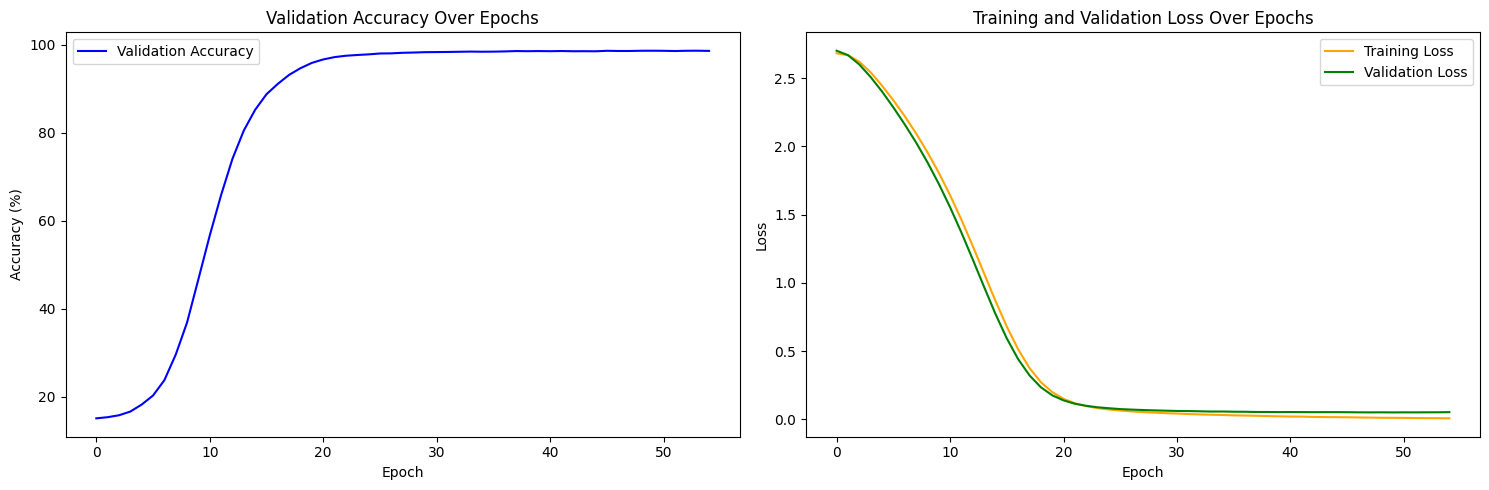

In [ ]:
metrics_C10_ViTB = train_and_evaluate('CIFAR10', 'vit_base_patch16_224', False)
plot_results(metrics_C10_ViTB)

Training ViT-B/16 on CIFAR-100 with R-Drop


=== Training vit_base_patch16_224 on CIFAR100 with R-Drop = True ===
Files already downloaded and verified
Files already downloaded and verified


<ipython-input-1-7853ca290e3b>:245: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [R-Drop Training] (CIFAR100, vit_base_patch16_224):   0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-1-7853ca290e3b>:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Epoch 1 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 1.02%
Epoch [1/90] Train Loss: 4.9339 Val Loss: 4.9470 Val Acc: 1.02% Time: 114.69s


Epoch 2 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 1.03%
Epoch [2/90] Train Loss: 4.9286 Val Loss: 4.9352 Val Acc: 1.03% Time: 115.27s


Epoch 3 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 1.05%
Epoch [3/90] Train Loss: 4.9097 Val Loss: 4.9099 Val Acc: 1.05% Time: 114.93s


Epoch 4 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 1.14%
Epoch [4/90] Train Loss: 4.8812 Val Loss: 4.8736 Val Acc: 1.14% Time: 114.82s


Epoch 5 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 1.18%
Epoch [5/90] Train Loss: 4.8426 Val Loss: 4.8303 Val Acc: 1.18% Time: 114.76s


Epoch 6 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 1.31%
Epoch [6/90] Train Loss: 4.7986 Val Loss: 4.7827 Val Acc: 1.31% Time: 114.72s


Epoch 7 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 1.39%
Epoch [7/90] Train Loss: 4.7522 Val Loss: 4.7330 Val Acc: 1.39% Time: 114.71s


Epoch 8 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 1.62%
Epoch [8/90] Train Loss: 4.7038 Val Loss: 4.6824 Val Acc: 1.62% Time: 114.77s


Epoch 9 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 1.91%
Epoch [9/90] Train Loss: 4.6543 Val Loss: 4.6310 Val Acc: 1.91% Time: 114.68s


Epoch 10 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 2.19%
Epoch [10/90] Train Loss: 4.6020 Val Loss: 4.5788 Val Acc: 2.19% Time: 114.90s


Epoch 11 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 2.65%
Epoch [11/90] Train Loss: 4.5498 Val Loss: 4.5250 Val Acc: 2.65% Time: 114.97s


Epoch 12 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.11it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 3.40%
Epoch [12/90] Train Loss: 4.4942 Val Loss: 4.4682 Val Acc: 3.40% Time: 115.20s


Epoch 13 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 4.19%
Epoch [13/90] Train Loss: 4.4348 Val Loss: 4.4059 Val Acc: 4.19% Time: 114.95s


Epoch 14 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 5.38%
Epoch [14/90] Train Loss: 4.3676 Val Loss: 4.3354 Val Acc: 5.38% Time: 114.76s


Epoch 15 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 6.98%
Epoch [15/90] Train Loss: 4.2905 Val Loss: 4.2541 Val Acc: 6.98% Time: 114.74s


Epoch 16 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 8.88%
Epoch [16/90] Train Loss: 4.2022 Val Loss: 4.1595 Val Acc: 8.88% Time: 114.94s


Epoch 17 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 11.00%
Epoch [17/90] Train Loss: 4.0966 Val Loss: 4.0500 Val Acc: 11.00% Time: 114.82s


Epoch 18 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 13.25%
Epoch [18/90] Train Loss: 3.9755 Val Loss: 3.9230 Val Acc: 13.25% Time: 114.92s


Epoch 19 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 16.06%
Epoch [19/90] Train Loss: 3.8361 Val Loss: 3.7781 Val Acc: 16.06% Time: 114.88s


Epoch 20 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.11it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 19.88%
Epoch [20/90] Train Loss: 3.6799 Val Loss: 3.6177 Val Acc: 19.88% Time: 114.93s


Epoch 21 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 24.05%
Epoch [21/90] Train Loss: 3.5066 Val Loss: 3.4373 Val Acc: 24.05% Time: 115.02s


Epoch 22 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 28.55%
Epoch [22/90] Train Loss: 3.3145 Val Loss: 3.2399 Val Acc: 28.55% Time: 114.88s


Epoch 23 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 33.51%
Epoch [23/90] Train Loss: 3.1032 Val Loss: 3.0257 Val Acc: 33.51% Time: 114.95s


Epoch 24 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 38.66%
Epoch [24/90] Train Loss: 2.8819 Val Loss: 2.8033 Val Acc: 38.66% Time: 114.89s


Epoch 25 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 43.19%
Epoch [25/90] Train Loss: 2.6536 Val Loss: 2.5819 Val Acc: 43.19% Time: 114.74s


Epoch 26 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 48.27%
Epoch [26/90] Train Loss: 2.4339 Val Loss: 2.3614 Val Acc: 48.27% Time: 115.00s


Epoch 27 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 53.33%
Epoch [27/90] Train Loss: 2.2149 Val Loss: 2.1466 Val Acc: 53.33% Time: 115.02s


Epoch 28 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 57.70%
Epoch [28/90] Train Loss: 2.0059 Val Loss: 1.9485 Val Acc: 57.70% Time: 114.77s


Epoch 29 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 61.97%
Epoch [29/90] Train Loss: 1.8110 Val Loss: 1.7571 Val Acc: 61.97% Time: 115.03s


Epoch 30 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 65.50%
Epoch [30/90] Train Loss: 1.6333 Val Loss: 1.5881 Val Acc: 65.50% Time: 114.71s


Epoch 31 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 68.78%
Epoch [31/90] Train Loss: 1.4711 Val Loss: 1.4333 Val Acc: 68.78% Time: 114.62s


Epoch 32 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 71.51%
Epoch [32/90] Train Loss: 1.3281 Val Loss: 1.3008 Val Acc: 71.51% Time: 114.82s


Epoch 33 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 73.91%
Epoch [33/90] Train Loss: 1.1980 Val Loss: 1.1756 Val Acc: 73.91% Time: 114.69s


Epoch 34 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 75.76%
Epoch [34/90] Train Loss: 1.0837 Val Loss: 1.0696 Val Acc: 75.76% Time: 114.54s


Epoch 35 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 77.27%
Epoch [35/90] Train Loss: 0.9867 Val Loss: 0.9792 Val Acc: 77.27% Time: 114.74s


Epoch 36 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 78.74%
Epoch [36/90] Train Loss: 0.9033 Val Loss: 0.9067 Val Acc: 78.74% Time: 114.87s


Epoch 37 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 79.81%
Epoch [37/90] Train Loss: 0.8321 Val Loss: 0.8422 Val Acc: 79.81% Time: 114.74s


Epoch 38 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 81.00%
Epoch [38/90] Train Loss: 0.7711 Val Loss: 0.7798 Val Acc: 81.00% Time: 114.61s


Epoch 39 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 81.94%
Epoch [39/90] Train Loss: 0.7128 Val Loss: 0.7288 Val Acc: 81.94% Time: 114.54s


Epoch 40 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 82.71%
Epoch [40/90] Train Loss: 0.6619 Val Loss: 0.6831 Val Acc: 82.71% Time: 114.60s


Epoch 41 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 83.56%
Epoch [41/90] Train Loss: 0.6201 Val Loss: 0.6445 Val Acc: 83.56% Time: 114.56s


Epoch 42 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 84.20%
Epoch [42/90] Train Loss: 0.5835 Val Loss: 0.6087 Val Acc: 84.20% Time: 114.57s


Epoch 43 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 84.86%
Epoch [43/90] Train Loss: 0.5482 Val Loss: 0.5794 Val Acc: 84.86% Time: 114.92s


Epoch 44 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 85.39%
Epoch [44/90] Train Loss: 0.5188 Val Loss: 0.5515 Val Acc: 85.39% Time: 114.98s


Epoch 45 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 85.98%
Epoch [45/90] Train Loss: 0.4892 Val Loss: 0.5271 Val Acc: 85.98% Time: 115.02s


Epoch 46 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 86.49%
Epoch [46/90] Train Loss: 0.4639 Val Loss: 0.5043 Val Acc: 86.49% Time: 114.95s


Epoch 47 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 86.99%
Epoch [47/90] Train Loss: 0.4414 Val Loss: 0.4831 Val Acc: 86.99% Time: 114.84s


Epoch 48 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 87.53%
Epoch [48/90] Train Loss: 0.4208 Val Loss: 0.4666 Val Acc: 87.53% Time: 114.86s


Epoch 49 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 87.76%
Epoch [49/90] Train Loss: 0.4015 Val Loss: 0.4524 Val Acc: 87.76% Time: 114.75s


Epoch 50 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 88.03%
Epoch [50/90] Train Loss: 0.3832 Val Loss: 0.4390 Val Acc: 88.03% Time: 114.78s


Epoch 51 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 88.33%
Epoch [51/90] Train Loss: 0.3665 Val Loss: 0.4255 Val Acc: 88.33% Time: 114.77s


Epoch 52 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 88.75%
Epoch [52/90] Train Loss: 0.3505 Val Loss: 0.4150 Val Acc: 88.75% Time: 114.58s


Epoch 53 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 88.92%
Epoch [53/90] Train Loss: 0.3393 Val Loss: 0.4062 Val Acc: 88.92% Time: 114.68s


Epoch 54 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [54/90] Train Loss: 0.3238 Val Loss: 0.3964 Val Acc: 88.85% Time: 113.96s


Epoch 55 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 89.36%
Epoch [55/90] Train Loss: 0.3124 Val Loss: 0.3875 Val Acc: 89.36% Time: 114.70s


Epoch 56 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 89.38%
Epoch [56/90] Train Loss: 0.3017 Val Loss: 0.3814 Val Acc: 89.38% Time: 114.57s


Epoch 57 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 89.48%
Epoch [57/90] Train Loss: 0.2910 Val Loss: 0.3747 Val Acc: 89.48% Time: 114.81s


Epoch 58 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 89.63%
Epoch [58/90] Train Loss: 0.2825 Val Loss: 0.3684 Val Acc: 89.63% Time: 114.78s


Epoch 59 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 89.83%
Epoch [59/90] Train Loss: 0.2723 Val Loss: 0.3622 Val Acc: 89.83% Time: 114.77s


Epoch 60 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 89.90%
Epoch [60/90] Train Loss: 0.2604 Val Loss: 0.3566 Val Acc: 89.90% Time: 114.57s


Epoch 61 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.03%
Epoch [61/90] Train Loss: 0.2519 Val Loss: 0.3524 Val Acc: 90.03% Time: 114.73s


Epoch 62 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 90.11%
Epoch [62/90] Train Loss: 0.2424 Val Loss: 0.3474 Val Acc: 90.11% Time: 114.90s


Epoch 63 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 90.24%
Epoch [63/90] Train Loss: 0.2362 Val Loss: 0.3428 Val Acc: 90.24% Time: 114.61s


Epoch 64 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [64/90] Train Loss: 0.2266 Val Loss: 0.3381 Val Acc: 90.22% Time: 113.80s


Epoch 65 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.54%
Epoch [65/90] Train Loss: 0.2200 Val Loss: 0.3354 Val Acc: 90.54% Time: 114.86s


Epoch 66 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.67%
Epoch [66/90] Train Loss: 0.2111 Val Loss: 0.3314 Val Acc: 90.67% Time: 114.57s


Epoch 67 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [67/90] Train Loss: 0.2059 Val Loss: 0.3281 Val Acc: 90.62% Time: 113.93s


Epoch 68 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [68/90] Train Loss: 0.1973 Val Loss: 0.3265 Val Acc: 90.63% Time: 113.95s


Epoch 69 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 90.70%
Epoch [69/90] Train Loss: 0.1906 Val Loss: 0.3267 Val Acc: 90.70% Time: 114.74s


Epoch 70 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 90.73%
Epoch [70/90] Train Loss: 0.1846 Val Loss: 0.3225 Val Acc: 90.73% Time: 114.70s


Epoch 71 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.91%
Epoch [71/90] Train Loss: 0.1785 Val Loss: 0.3181 Val Acc: 90.91% Time: 114.66s


Epoch 72 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [72/90] Train Loss: 0.1714 Val Loss: 0.3200 Val Acc: 90.87% Time: 113.73s


Epoch 73 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 90.96%
Epoch [73/90] Train Loss: 0.1648 Val Loss: 0.3164 Val Acc: 90.96% Time: 114.61s


Epoch 74 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [74/90] Train Loss: 0.1602 Val Loss: 0.3161 Val Acc: 90.85% Time: 114.05s


Epoch 75 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 91.08%
Epoch [75/90] Train Loss: 0.1541 Val Loss: 0.3135 Val Acc: 91.08% Time: 114.66s


Epoch 76 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.12it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [76/90] Train Loss: 0.1479 Val Loss: 0.3124 Val Acc: 91.05% Time: 114.06s


Epoch 77 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Epoch [77/90] Train Loss: 0.1438 Val Loss: 0.3142 Val Acc: 91.08% Time: 113.95s


Epoch 78 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 91.14%
Epoch [78/90] Train Loss: 0.1380 Val Loss: 0.3128 Val Acc: 91.14% Time: 114.50s


Epoch 79 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 91.25%
Epoch [79/90] Train Loss: 0.1331 Val Loss: 0.3111 Val Acc: 91.25% Time: 114.52s


Epoch 80 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 91.49%
Epoch [80/90] Train Loss: 0.1294 Val Loss: 0.3098 Val Acc: 91.49% Time: 114.64s


Epoch 81 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [81/90] Train Loss: 0.1227 Val Loss: 0.3096 Val Acc: 91.23% Time: 113.87s


Epoch 82 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Epoch [82/90] Train Loss: 0.1175 Val Loss: 0.3118 Val Acc: 91.24% Time: 113.70s


Epoch 83 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Epoch [83/90] Train Loss: 0.1124 Val Loss: 0.3105 Val Acc: 91.26% Time: 113.84s


Epoch 84 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [84/90] Train Loss: 0.1087 Val Loss: 0.3108 Val Acc: 91.12% Time: 113.90s


Epoch 85 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:31<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [85/90] Train Loss: 0.1046 Val Loss: 0.3117 Val Acc: 91.39% Time: 113.66s


Epoch 86 [R-Drop Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [01:32<00:00,  2.13it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Epoch [86/90] Train Loss: 0.1002 Val Loss: 0.3119 Val Acc: 91.21% Time: 113.87s
Early stopping triggered.
Training completed for vit_base_patch16_224 on CIFAR100 with R-Drop = True
Best Validation Accuracy: 91.49%



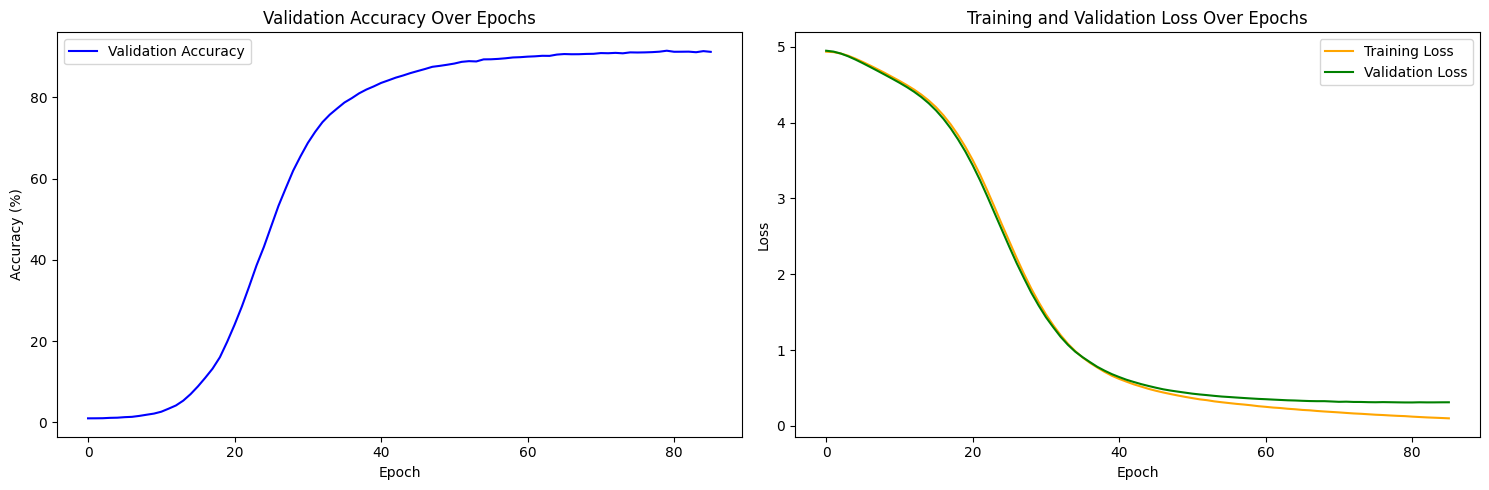

In [ ]:
metrics_C100_ViTB_RDrop = train_and_evaluate('CIFAR100', 'vit_base_patch16_224', True, 5)
plot_results(metrics_C100_ViTB_RDrop)

Training ViT-B/16 on CIFAR-100


=== Training vit_base_patch16_224 on CIFAR100 with R-Drop = False ===
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-1-7853ca290e3b>:245: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [Standard Training] (CIFAR100, vit_base_patch16_224):   0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-1-7853ca290e3b>:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is 

Best model saved with accuracy: 1.02%
Epoch [1/86] Train Loss: 4.9339 Val Loss: 4.9470 Val Acc: 1.02% Time: 72.11s


Epoch 2 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 1.03%
Epoch [2/86] Train Loss: 4.9286 Val Loss: 4.9352 Val Acc: 1.03% Time: 70.66s


Epoch 3 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 1.05%
Epoch [3/86] Train Loss: 4.9097 Val Loss: 4.9099 Val Acc: 1.05% Time: 70.56s


Epoch 4 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 1.14%
Epoch [4/86] Train Loss: 4.8812 Val Loss: 4.8735 Val Acc: 1.14% Time: 70.70s


Epoch 5 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 1.19%
Epoch [5/86] Train Loss: 4.8426 Val Loss: 4.8302 Val Acc: 1.19% Time: 70.78s


Epoch 6 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 1.30%
Epoch [6/86] Train Loss: 4.7986 Val Loss: 4.7826 Val Acc: 1.30% Time: 70.53s


Epoch 7 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Best model saved with accuracy: 1.40%
Epoch [7/86] Train Loss: 4.7522 Val Loss: 4.7330 Val Acc: 1.40% Time: 70.57s


Epoch 8 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 1.63%
Epoch [8/86] Train Loss: 4.7038 Val Loss: 4.6825 Val Acc: 1.63% Time: 70.54s


Epoch 9 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 1.89%
Epoch [9/86] Train Loss: 4.6543 Val Loss: 4.6311 Val Acc: 1.89% Time: 70.65s


Epoch 10 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 2.17%
Epoch [10/86] Train Loss: 4.6020 Val Loss: 4.5787 Val Acc: 2.17% Time: 70.53s


Epoch 11 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 2.65%
Epoch [11/86] Train Loss: 4.5497 Val Loss: 4.5249 Val Acc: 2.65% Time: 70.55s


Epoch 12 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 3.32%
Epoch [12/86] Train Loss: 4.4941 Val Loss: 4.4680 Val Acc: 3.32% Time: 70.53s


Epoch 13 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 4.22%
Epoch [13/86] Train Loss: 4.4346 Val Loss: 4.4056 Val Acc: 4.22% Time: 70.71s


Epoch 14 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 5.42%
Epoch [14/86] Train Loss: 4.3674 Val Loss: 4.3353 Val Acc: 5.42% Time: 70.75s


Epoch 15 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 6.96%
Epoch [15/86] Train Loss: 4.2904 Val Loss: 4.2542 Val Acc: 6.96% Time: 70.59s


Epoch 16 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 8.82%
Epoch [16/86] Train Loss: 4.2022 Val Loss: 4.1599 Val Acc: 8.82% Time: 70.61s


Epoch 17 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 10.90%
Epoch [17/86] Train Loss: 4.0969 Val Loss: 4.0503 Val Acc: 10.90% Time: 70.77s


Epoch 18 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 13.23%
Epoch [18/86] Train Loss: 3.9762 Val Loss: 3.9237 Val Acc: 13.23% Time: 70.70s


Epoch 19 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 15.98%
Epoch [19/86] Train Loss: 3.8374 Val Loss: 3.7797 Val Acc: 15.98% Time: 70.65s


Epoch 20 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 19.83%
Epoch [20/86] Train Loss: 3.6813 Val Loss: 3.6187 Val Acc: 19.83% Time: 70.77s


Epoch 21 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 23.91%
Epoch [21/86] Train Loss: 3.5078 Val Loss: 3.4386 Val Acc: 23.91% Time: 70.70s


Epoch 22 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 28.38%
Epoch [22/86] Train Loss: 3.3152 Val Loss: 3.2409 Val Acc: 28.38% Time: 70.67s


Epoch 23 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 33.66%
Epoch [23/86] Train Loss: 3.1045 Val Loss: 3.0267 Val Acc: 33.66% Time: 70.63s


Epoch 24 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 38.72%
Epoch [24/86] Train Loss: 2.8816 Val Loss: 2.8016 Val Acc: 38.72% Time: 70.74s


Epoch 25 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 43.23%
Epoch [25/86] Train Loss: 2.6534 Val Loss: 2.5816 Val Acc: 43.23% Time: 70.57s


Epoch 26 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 48.16%
Epoch [26/86] Train Loss: 2.4299 Val Loss: 2.3587 Val Acc: 48.16% Time: 70.58s


Epoch 27 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 53.31%
Epoch [27/86] Train Loss: 2.2128 Val Loss: 2.1476 Val Acc: 53.31% Time: 70.78s


Epoch 28 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 57.16%
Epoch [28/86] Train Loss: 2.0164 Val Loss: 1.9666 Val Acc: 57.16% Time: 70.64s


Epoch 29 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 61.66%
Epoch [29/86] Train Loss: 1.8278 Val Loss: 1.7718 Val Acc: 61.66% Time: 70.72s


Epoch 30 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 65.47%
Epoch [30/86] Train Loss: 1.6422 Val Loss: 1.5924 Val Acc: 65.47% Time: 70.63s


Epoch 31 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 68.89%
Epoch [31/86] Train Loss: 1.4721 Val Loss: 1.4307 Val Acc: 68.89% Time: 70.71s


Epoch 32 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 71.71%
Epoch [32/86] Train Loss: 1.3198 Val Loss: 1.2909 Val Acc: 71.71% Time: 70.68s


Epoch 33 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 74.08%
Epoch [33/86] Train Loss: 1.1886 Val Loss: 1.1688 Val Acc: 74.08% Time: 70.67s


Epoch 34 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 76.04%
Epoch [34/86] Train Loss: 1.0768 Val Loss: 1.0633 Val Acc: 76.04% Time: 70.75s


Epoch 35 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 77.76%
Epoch [35/86] Train Loss: 0.9790 Val Loss: 0.9697 Val Acc: 77.76% Time: 70.69s


Epoch 36 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.05it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 79.02%
Epoch [36/86] Train Loss: 0.8928 Val Loss: 0.8939 Val Acc: 79.02% Time: 70.83s


Epoch 37 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 80.33%
Epoch [37/86] Train Loss: 0.8203 Val Loss: 0.8270 Val Acc: 80.33% Time: 70.63s


Epoch 38 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 81.13%
Epoch [38/86] Train Loss: 0.7594 Val Loss: 0.7715 Val Acc: 81.13% Time: 70.76s


Epoch 39 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 82.13%
Epoch [39/86] Train Loss: 0.7044 Val Loss: 0.7229 Val Acc: 82.13% Time: 70.69s


Epoch 40 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.21it/s]


Best model saved with accuracy: 82.95%
Epoch [40/86] Train Loss: 0.6569 Val Loss: 0.6795 Val Acc: 82.95% Time: 70.69s


Epoch 41 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 83.76%
Epoch [41/86] Train Loss: 0.6174 Val Loss: 0.6419 Val Acc: 83.76% Time: 70.28s


Epoch 42 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 84.49%
Epoch [42/86] Train Loss: 0.5816 Val Loss: 0.6052 Val Acc: 84.49% Time: 70.59s


Epoch 43 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 84.95%
Epoch [43/86] Train Loss: 0.5447 Val Loss: 0.5748 Val Acc: 84.95% Time: 70.73s


Epoch 44 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 85.43%
Epoch [44/86] Train Loss: 0.5146 Val Loss: 0.5489 Val Acc: 85.43% Time: 70.57s


Epoch 45 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 85.95%
Epoch [45/86] Train Loss: 0.4862 Val Loss: 0.5244 Val Acc: 85.95% Time: 70.54s


Epoch 46 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 86.57%
Epoch [46/86] Train Loss: 0.4624 Val Loss: 0.5027 Val Acc: 86.57% Time: 70.73s


Epoch 47 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 87.06%
Epoch [47/86] Train Loss: 0.4411 Val Loss: 0.4852 Val Acc: 87.06% Time: 70.82s


Epoch 48 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 87.38%
Epoch [48/86] Train Loss: 0.4210 Val Loss: 0.4689 Val Acc: 87.38% Time: 70.76s


Epoch 49 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 87.66%
Epoch [49/86] Train Loss: 0.4039 Val Loss: 0.4547 Val Acc: 87.66% Time: 70.72s


Epoch 50 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 87.99%
Epoch [50/86] Train Loss: 0.3859 Val Loss: 0.4405 Val Acc: 87.99% Time: 70.81s


Epoch 51 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 88.22%
Epoch [51/86] Train Loss: 0.3684 Val Loss: 0.4297 Val Acc: 88.22% Time: 70.81s


Epoch 52 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 88.57%
Epoch [52/86] Train Loss: 0.3534 Val Loss: 0.4157 Val Acc: 88.57% Time: 70.70s


Epoch 53 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


Best model saved with accuracy: 88.77%
Epoch [53/86] Train Loss: 0.3416 Val Loss: 0.4073 Val Acc: 88.77% Time: 70.76s


Epoch 54 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 88.86%
Epoch [54/86] Train Loss: 0.3255 Val Loss: 0.3986 Val Acc: 88.86% Time: 70.87s


Epoch 55 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 89.17%
Epoch [55/86] Train Loss: 0.3130 Val Loss: 0.3892 Val Acc: 89.17% Time: 70.61s


Epoch 56 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 89.39%
Epoch [56/86] Train Loss: 0.3021 Val Loss: 0.3814 Val Acc: 89.39% Time: 70.57s


Epoch 57 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [57/86] Train Loss: 0.2905 Val Loss: 0.3765 Val Acc: 89.32% Time: 69.94s


Epoch 58 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 89.54%
Epoch [58/86] Train Loss: 0.2826 Val Loss: 0.3686 Val Acc: 89.54% Time: 70.74s


Epoch 59 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 89.76%
Epoch [59/86] Train Loss: 0.2720 Val Loss: 0.3607 Val Acc: 89.76% Time: 70.61s


Epoch 60 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 89.87%
Epoch [60/86] Train Loss: 0.2609 Val Loss: 0.3564 Val Acc: 89.87% Time: 70.67s


Epoch 61 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 89.88%
Epoch [61/86] Train Loss: 0.2529 Val Loss: 0.3529 Val Acc: 89.88% Time: 70.44s


Epoch 62 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 89.99%
Epoch [62/86] Train Loss: 0.2433 Val Loss: 0.3483 Val Acc: 89.99% Time: 70.47s


Epoch 63 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 90.09%
Epoch [63/86] Train Loss: 0.2384 Val Loss: 0.3430 Val Acc: 90.09% Time: 70.49s


Epoch 64 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.17%
Epoch [64/86] Train Loss: 0.2283 Val Loss: 0.3394 Val Acc: 90.17% Time: 70.62s


Epoch 65 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.39%
Epoch [65/86] Train Loss: 0.2212 Val Loss: 0.3368 Val Acc: 90.39% Time: 70.46s


Epoch 66 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Best model saved with accuracy: 90.51%
Epoch [66/86] Train Loss: 0.2119 Val Loss: 0.3326 Val Acc: 90.51% Time: 70.47s


Epoch 67 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 90.52%
Epoch [67/86] Train Loss: 0.2064 Val Loss: 0.3291 Val Acc: 90.52% Time: 70.51s


Epoch 68 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [68/86] Train Loss: 0.1975 Val Loss: 0.3303 Val Acc: 90.51% Time: 69.68s


Epoch 69 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.57%
Epoch [69/86] Train Loss: 0.1912 Val Loss: 0.3258 Val Acc: 90.57% Time: 70.70s


Epoch 70 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.06it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 90.67%
Epoch [70/86] Train Loss: 0.1848 Val Loss: 0.3233 Val Acc: 90.67% Time: 70.80s


Epoch 71 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 90.71%
Epoch [71/86] Train Loss: 0.1795 Val Loss: 0.3202 Val Acc: 90.71% Time: 70.60s


Epoch 72 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.79%
Epoch [72/86] Train Loss: 0.1719 Val Loss: 0.3203 Val Acc: 90.79% Time: 70.68s


Epoch 73 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Best model saved with accuracy: 90.91%
Epoch [73/86] Train Loss: 0.1650 Val Loss: 0.3173 Val Acc: 90.91% Time: 70.58s


Epoch 74 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Epoch [74/86] Train Loss: 0.1618 Val Loss: 0.3176 Val Acc: 90.85% Time: 69.92s


Epoch 75 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 91.06%
Epoch [75/86] Train Loss: 0.1555 Val Loss: 0.3155 Val Acc: 91.06% Time: 70.60s


Epoch 76 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 91.10%
Epoch [76/86] Train Loss: 0.1487 Val Loss: 0.3143 Val Acc: 91.10% Time: 70.72s


Epoch 77 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.26it/s]


Epoch [77/86] Train Loss: 0.1444 Val Loss: 0.3146 Val Acc: 91.10% Time: 69.66s


Epoch 78 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [78/86] Train Loss: 0.1390 Val Loss: 0.3141 Val Acc: 90.91% Time: 69.83s


Epoch 79 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Best model saved with accuracy: 91.15%
Epoch [79/86] Train Loss: 0.1342 Val Loss: 0.3130 Val Acc: 91.15% Time: 70.66s


Epoch 80 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:47<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Best model saved with accuracy: 91.27%
Epoch [80/86] Train Loss: 0.1303 Val Loss: 0.3117 Val Acc: 91.27% Time: 70.49s


Epoch 81 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.07it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [81/86] Train Loss: 0.1243 Val Loss: 0.3127 Val Acc: 91.21% Time: 69.84s


Epoch 82 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Epoch [82/86] Train Loss: 0.1187 Val Loss: 0.3124 Val Acc: 91.25% Time: 69.78s


Epoch 83 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [83/86] Train Loss: 0.1129 Val Loss: 0.3123 Val Acc: 91.23% Time: 69.71s


Epoch 84 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [84/86] Train Loss: 0.1090 Val Loss: 0.3140 Val Acc: 91.17% Time: 69.74s


Epoch 85 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.25it/s]


Epoch [85/86] Train Loss: 0.1057 Val Loss: 0.3137 Val Acc: 91.22% Time: 69.72s


Epoch 86 [Standard Training] (CIFAR100, vit_base_patch16_224): 100%|██████████| 196/196 [00:48<00:00,  4.08it/s]
Evaluating (CIFAR100, vit_base_patch16_224): 100%|██████████| 157/157 [00:21<00:00,  7.24it/s]


Epoch [86/86] Train Loss: 0.1010 Val Loss: 0.3131 Val Acc: 91.23% Time: 69.74s
Training completed for vit_base_patch16_224 on CIFAR100 with R-Drop = False
Best Validation Accuracy: 91.27%



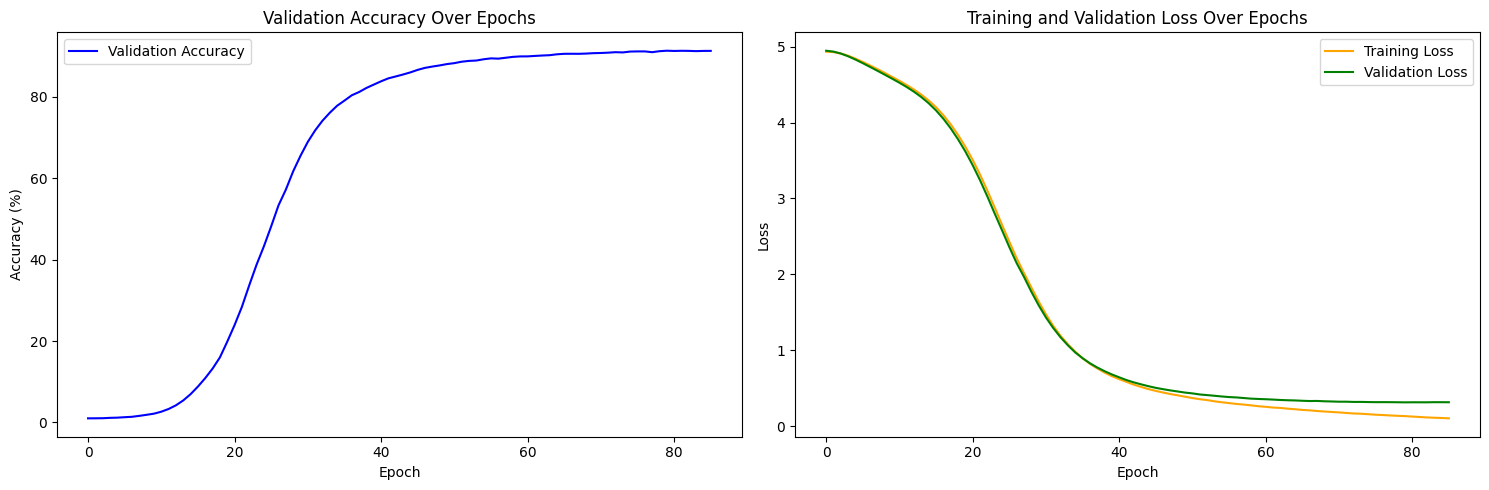

In [ ]:
metrics_C100_ViTB = train_and_evaluate('CIFAR100', 'vit_base_patch16_224', False)
plot_results(metrics_C100_ViTB)

Training ViT-L/16 on CIFAR-100 with R-Drop

In [ ]:
metrics_C100_ViTL_RDrop = train_and_evaluate('CIFAR100', 'vit_large_patch16_224', True, 3)
plot_results(metrics_C100_ViTL_RDrop)


=== Training vit_large_patch16_224 on CIFAR100 with R-Drop = True ===
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-3-7853ca290e3b>:245: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [R-Drop Training] (CIFAR100, vit_large_patch16_224):   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-3-7853ca290e3b>:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is n

Best model saved with accuracy: 0.77%
Epoch [1/85] Train Loss: 5.9661 Val Loss: 6.0019 Val Acc: 0.77% Time: 374.26s


Epoch 2 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 0.82%
Epoch [2/85] Train Loss: 5.9338 Val Loss: 5.9449 Val Acc: 0.82% Time: 373.02s


Epoch 3 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 0.95%
Epoch [3/85] Train Loss: 5.8449 Val Loss: 5.8415 Val Acc: 0.95% Time: 373.11s


Epoch 4 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 1.13%
Epoch [4/85] Train Loss: 5.7142 Val Loss: 5.7021 Val Acc: 1.13% Time: 373.10s


Epoch 5 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 1.37%
Epoch [5/85] Train Loss: 5.5497 Val Loss: 5.5256 Val Acc: 1.37% Time: 373.31s


Epoch 6 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 1.74%
Epoch [6/85] Train Loss: 5.3519 Val Loss: 5.3314 Val Acc: 1.74% Time: 372.87s


Epoch 7 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 2.14%
Epoch [7/85] Train Loss: 5.1392 Val Loss: 5.1279 Val Acc: 2.14% Time: 373.09s


Epoch 8 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 3.07%
Epoch [8/85] Train Loss: 4.9089 Val Loss: 4.8819 Val Acc: 3.07% Time: 373.05s


Epoch 9 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 4.32%
Epoch [9/85] Train Loss: 4.6375 Val Loss: 4.6191 Val Acc: 4.32% Time: 373.12s


Epoch 10 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 6.56%
Epoch [10/85] Train Loss: 4.3425 Val Loss: 4.3278 Val Acc: 6.56% Time: 373.05s


Epoch 11 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 11.02%
Epoch [11/85] Train Loss: 4.0142 Val Loss: 3.9999 Val Acc: 11.02% Time: 372.94s


Epoch 12 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 17.47%
Epoch [12/85] Train Loss: 3.6731 Val Loss: 3.6753 Val Acc: 17.47% Time: 373.04s


Epoch 13 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 25.16%
Epoch [13/85] Train Loss: 3.3299 Val Loss: 3.3441 Val Acc: 25.16% Time: 372.77s


Epoch 14 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 34.64%
Epoch [14/85] Train Loss: 2.9603 Val Loss: 2.9798 Val Acc: 34.64% Time: 372.91s


Epoch 15 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 45.34%
Epoch [15/85] Train Loss: 2.5649 Val Loss: 2.5869 Val Acc: 45.34% Time: 373.02s


Epoch 16 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 54.99%
Epoch [16/85] Train Loss: 2.1811 Val Loss: 2.2315 Val Acc: 54.99% Time: 372.66s


Epoch 17 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 62.65%
Epoch [17/85] Train Loss: 1.8264 Val Loss: 1.8860 Val Acc: 62.65% Time: 372.76s


Epoch 18 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 69.50%
Epoch [18/85] Train Loss: 1.5065 Val Loss: 1.5745 Val Acc: 69.50% Time: 372.80s


Epoch 19 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 74.43%
Epoch [19/85] Train Loss: 1.2326 Val Loss: 1.3122 Val Acc: 74.43% Time: 372.85s


Epoch 20 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.62it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 78.44%
Epoch [20/85] Train Loss: 1.0013 Val Loss: 1.0813 Val Acc: 78.44% Time: 372.40s


Epoch 21 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:58<00:00,  2.62it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 81.21%
Epoch [21/85] Train Loss: 0.8183 Val Loss: 0.9088 Val Acc: 81.21% Time: 372.18s


Epoch 22 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:58<00:00,  2.62it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 83.05%
Epoch [22/85] Train Loss: 0.6896 Val Loss: 0.7805 Val Acc: 83.05% Time: 372.65s


Epoch 23 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:59<00:00,  2.61it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 85.05%
Epoch [23/85] Train Loss: 0.5964 Val Loss: 0.6803 Val Acc: 85.05% Time: 372.80s


Epoch 24 [R-Drop Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [04:58<00:00,  2.62it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 86.34%
Epoch [24/85] Train Loss: 0.5207 Val Loss: 0.5971 Val Acc: 86.34% Time: 372.39s


Epoch 25 [R-Drop Training] (CIFAR100, vit_large_patch16_224):   2%|▏         | 13/782 [00:05<05:39,  2.27it/s]


KeyboardInterrupt: 

Training ViT-L/16 on CIFAR-100


=== Training vit_large_patch16_224 on CIFAR100 with R-Drop = False ===


100%|██████████| 169M/169M [00:02<00:00, 81.2MB/s]


Extracting ./data/CIFAR100/cifar-100-python.tar.gz to ./data/CIFAR100
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

<ipython-input-1-7853ca290e3b>:245: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [Standard Training] (CIFAR100, vit_large_patch16_224):   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-1-7853ca290e3b>:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):
Epoch 1 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:32<00:00,  5.14it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 0.77%
Epoch [1/24] Train Loss: 5.9661 Val Loss: 6.0019 Val Acc: 0.77% Time: 225.09s


Epoch 2 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 0.82%
Epoch [2/24] Train Loss: 5.9369 Val Loss: 5.9481 Val Acc: 0.82% Time: 224.23s


Epoch 3 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 0.93%
Epoch [3/24] Train Loss: 5.8483 Val Loss: 5.8437 Val Acc: 0.93% Time: 224.32s


Epoch 4 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 1.11%
Epoch [4/24] Train Loss: 5.7148 Val Loss: 5.6969 Val Acc: 1.11% Time: 224.19s


Epoch 5 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 1.36%
Epoch [5/24] Train Loss: 5.5400 Val Loss: 5.5180 Val Acc: 1.36% Time: 224.21s


Epoch 6 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 1.75%
Epoch [6/24] Train Loss: 5.3463 Val Loss: 5.3253 Val Acc: 1.75% Time: 224.21s


Epoch 7 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 2.15%
Epoch [7/24] Train Loss: 5.1351 Val Loss: 5.1237 Val Acc: 2.15% Time: 224.04s


Epoch 8 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 3.00%
Epoch [8/24] Train Loss: 4.9115 Val Loss: 4.8922 Val Acc: 3.00% Time: 224.43s


Epoch 9 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 4.33%
Epoch [9/24] Train Loss: 4.6413 Val Loss: 4.6233 Val Acc: 4.33% Time: 224.49s


Epoch 10 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 6.50%
Epoch [10/24] Train Loss: 4.3492 Val Loss: 4.3351 Val Acc: 6.50% Time: 224.20s


Epoch 11 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 10.22%
Epoch [11/24] Train Loss: 4.0498 Val Loss: 4.0583 Val Acc: 10.22% Time: 225.30s


Epoch 12 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 15.86%
Epoch [12/24] Train Loss: 3.7370 Val Loss: 3.7442 Val Acc: 15.86% Time: 224.08s


Epoch 13 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 23.88%
Epoch [13/24] Train Loss: 3.3914 Val Loss: 3.3918 Val Acc: 23.88% Time: 224.01s


Epoch 14 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 33.90%
Epoch [14/24] Train Loss: 2.9979 Val Loss: 3.0023 Val Acc: 33.90% Time: 224.20s


Epoch 15 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 44.74%
Epoch [15/24] Train Loss: 2.5912 Val Loss: 2.6057 Val Acc: 44.74% Time: 226.85s


Epoch 16 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 55.74%
Epoch [16/24] Train Loss: 2.1706 Val Loss: 2.1928 Val Acc: 55.74% Time: 224.58s


Epoch 17 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 63.63%
Epoch [17/24] Train Loss: 1.7909 Val Loss: 1.8452 Val Acc: 63.63% Time: 224.36s


Epoch 18 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:31<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 70.10%
Epoch [18/24] Train Loss: 1.4688 Val Loss: 1.5405 Val Acc: 70.10% Time: 224.48s


Epoch 19 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 75.09%
Epoch [19/24] Train Loss: 1.2031 Val Loss: 1.2861 Val Acc: 75.09% Time: 225.48s


Epoch 20 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 78.18%
Epoch [20/24] Train Loss: 0.9911 Val Loss: 1.0829 Val Acc: 78.18% Time: 224.65s


Epoch 21 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 81.05%
Epoch [21/24] Train Loss: 0.8251 Val Loss: 0.9144 Val Acc: 81.05% Time: 225.22s


Epoch 22 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 83.09%
Epoch [22/24] Train Loss: 0.6946 Val Loss: 0.7827 Val Acc: 83.09% Time: 224.27s


Epoch 23 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.18it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 85.11%
Epoch [23/24] Train Loss: 0.5912 Val Loss: 0.6699 Val Acc: 85.11% Time: 224.36s


Epoch 24 [Standard Training] (CIFAR100, vit_large_patch16_224): 100%|██████████| 782/782 [02:30<00:00,  5.19it/s]
Evaluating (CIFAR100, vit_large_patch16_224): 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Best model saved with accuracy: 86.31%
Epoch [24/24] Train Loss: 0.5107 Val Loss: 0.5922 Val Acc: 86.31% Time: 224.49s
Training completed for vit_large_patch16_224 on CIFAR100 with R-Drop = False
Best Validation Accuracy: 86.31%



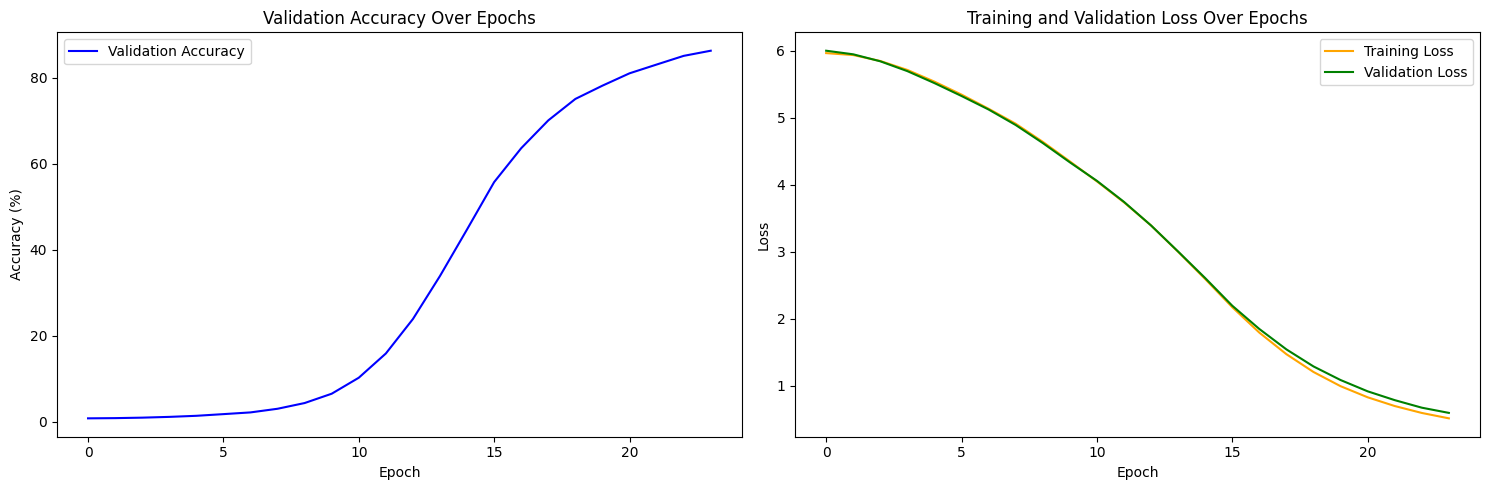

In [3]:
metrics_C100_ViTL = train_and_evaluate('CIFAR100', 'vit_large_patch16_224', False)
plot_results(metrics_C100_ViTL)

Training VGG-16 on CIFAR-100 with R-Drop (alpha=0.6)


=== Training vgg16 on CIFAR100 with R-Drop = True ===


100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


Extracting ./data/CIFAR100/cifar-100-python.tar.gz to ./data/CIFAR100
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]
<ipython-input-1-24122c3ba320>:307: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [R-Drop Tra

Best model saved with accuracy: 1.57%
Epoch [1/60] Train Loss: 4.7774 Val Loss: 4.6379 Val Acc: 1.57% Time: 110.89s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.99it/s]


Epoch [2/60] Train Loss: 4.7758 Val Loss: 4.6359 Val Acc: 1.55% Time: 106.32s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Epoch [3/60] Train Loss: 4.7668 Val Loss: 4.6314 Val Acc: 1.55% Time: 106.43s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Epoch [4/60] Train Loss: 4.7523 Val Loss: 4.6247 Val Acc: 1.57% Time: 106.60s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 1.61%
Epoch [5/60] Train Loss: 4.7366 Val Loss: 4.6163 Val Acc: 1.61% Time: 107.94s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Best model saved with accuracy: 1.69%
Epoch [6/60] Train Loss: 4.7145 Val Loss: 4.6069 Val Acc: 1.69% Time: 108.09s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Epoch [7/60] Train Loss: 4.6913 Val Loss: 4.5969 Val Acc: 1.66% Time: 106.35s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.90it/s]


Epoch [8/60] Train Loss: 4.6689 Val Loss: 4.5864 Val Acc: 1.68% Time: 106.58s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 1.89%
Epoch [9/60] Train Loss: 4.6503 Val Loss: 4.5753 Val Acc: 1.89% Time: 108.04s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 2.27%
Epoch [10/60] Train Loss: 4.6304 Val Loss: 4.5624 Val Acc: 2.27% Time: 107.92s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


Best model saved with accuracy: 2.75%
Epoch [11/60] Train Loss: 4.6117 Val Loss: 4.5470 Val Acc: 2.75% Time: 107.89s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 3.48%
Epoch [12/60] Train Loss: 4.5935 Val Loss: 4.5290 Val Acc: 3.48% Time: 108.03s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Best model saved with accuracy: 4.32%
Epoch [13/60] Train Loss: 4.5708 Val Loss: 4.5085 Val Acc: 4.32% Time: 108.06s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 5.70%
Epoch [14/60] Train Loss: 4.5500 Val Loss: 4.4858 Val Acc: 5.70% Time: 108.06s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 7.26%
Epoch [15/60] Train Loss: 4.5248 Val Loss: 4.4602 Val Acc: 7.26% Time: 108.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 8.90%
Epoch [16/60] Train Loss: 4.4997 Val Loss: 4.4309 Val Acc: 8.90% Time: 107.92s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 10.83%
Epoch [17/60] Train Loss: 4.4710 Val Loss: 4.3971 Val Acc: 10.83% Time: 108.04s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 25.02it/s]


Best model saved with accuracy: 12.94%
Epoch [18/60] Train Loss: 4.4395 Val Loss: 4.3579 Val Acc: 12.94% Time: 108.09s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 14.51%
Epoch [19/60] Train Loss: 4.4009 Val Loss: 4.3118 Val Acc: 14.51% Time: 108.12s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.97it/s]


Best model saved with accuracy: 16.53%
Epoch [20/60] Train Loss: 4.3575 Val Loss: 4.2572 Val Acc: 16.53% Time: 107.95s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.89it/s]


Best model saved with accuracy: 18.34%
Epoch [21/60] Train Loss: 4.3048 Val Loss: 4.1925 Val Acc: 18.34% Time: 107.91s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


Best model saved with accuracy: 20.15%
Epoch [22/60] Train Loss: 4.2461 Val Loss: 4.1160 Val Acc: 20.15% Time: 108.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 21.68%
Epoch [23/60] Train Loss: 4.1776 Val Loss: 4.0255 Val Acc: 21.68% Time: 107.64s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 23.24%
Epoch [24/60] Train Loss: 4.0975 Val Loss: 3.9194 Val Acc: 23.24% Time: 107.88s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.66it/s]


Best model saved with accuracy: 24.72%
Epoch [25/60] Train Loss: 4.0096 Val Loss: 3.7970 Val Acc: 24.72% Time: 107.94s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 26.43%
Epoch [26/60] Train Loss: 3.9122 Val Loss: 3.6605 Val Acc: 26.43% Time: 107.85s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Best model saved with accuracy: 27.98%
Epoch [27/60] Train Loss: 3.8068 Val Loss: 3.5133 Val Acc: 27.98% Time: 107.81s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.94it/s]


Best model saved with accuracy: 29.89%
Epoch [28/60] Train Loss: 3.7008 Val Loss: 3.3614 Val Acc: 29.89% Time: 107.83s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.64it/s]


Best model saved with accuracy: 31.66%
Epoch [29/60] Train Loss: 3.5872 Val Loss: 3.2099 Val Acc: 31.66% Time: 107.91s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


Best model saved with accuracy: 33.65%
Epoch [30/60] Train Loss: 3.4820 Val Loss: 3.0669 Val Acc: 33.65% Time: 108.02s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 35.69%
Epoch [31/60] Train Loss: 3.3743 Val Loss: 2.9345 Val Acc: 35.69% Time: 107.92s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 37.66%
Epoch [32/60] Train Loss: 3.2703 Val Loss: 2.8114 Val Acc: 37.66% Time: 107.84s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.68it/s]


Best model saved with accuracy: 39.35%
Epoch [33/60] Train Loss: 3.1748 Val Loss: 2.6991 Val Acc: 39.35% Time: 107.81s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.82it/s]


Best model saved with accuracy: 41.46%
Epoch [34/60] Train Loss: 3.0780 Val Loss: 2.5915 Val Acc: 41.46% Time: 107.83s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.71it/s]


Best model saved with accuracy: 43.16%
Epoch [35/60] Train Loss: 2.9878 Val Loss: 2.4909 Val Acc: 43.16% Time: 108.02s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


Best model saved with accuracy: 44.79%
Epoch [36/60] Train Loss: 2.9011 Val Loss: 2.3998 Val Acc: 44.79% Time: 107.88s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Best model saved with accuracy: 46.42%
Epoch [37/60] Train Loss: 2.8177 Val Loss: 2.3122 Val Acc: 46.42% Time: 108.60s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Best model saved with accuracy: 47.60%
Epoch [38/60] Train Loss: 2.7347 Val Loss: 2.2323 Val Acc: 47.60% Time: 108.05s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.71it/s]


Best model saved with accuracy: 48.90%
Epoch [39/60] Train Loss: 2.6617 Val Loss: 2.1558 Val Acc: 48.90% Time: 107.86s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Best model saved with accuracy: 50.07%
Epoch [40/60] Train Loss: 2.5840 Val Loss: 2.0840 Val Acc: 50.07% Time: 107.97s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 51.07%
Epoch [41/60] Train Loss: 2.5179 Val Loss: 2.0194 Val Acc: 51.07% Time: 107.82s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


Best model saved with accuracy: 52.15%
Epoch [42/60] Train Loss: 2.4539 Val Loss: 1.9566 Val Acc: 52.15% Time: 107.71s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 52.82%
Epoch [43/60] Train Loss: 2.3909 Val Loss: 1.9038 Val Acc: 52.82% Time: 107.89s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 53.67%
Epoch [44/60] Train Loss: 2.3326 Val Loss: 1.8464 Val Acc: 53.67% Time: 107.96s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.82it/s]


Best model saved with accuracy: 54.63%
Epoch [45/60] Train Loss: 2.2823 Val Loss: 1.7976 Val Acc: 54.63% Time: 107.96s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.69it/s]


Best model saved with accuracy: 55.19%
Epoch [46/60] Train Loss: 2.2229 Val Loss: 1.7511 Val Acc: 55.19% Time: 107.90s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.93it/s]


Best model saved with accuracy: 55.70%
Epoch [47/60] Train Loss: 2.1800 Val Loss: 1.7091 Val Acc: 55.70% Time: 107.59s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 56.46%
Epoch [48/60] Train Loss: 2.1382 Val Loss: 1.6707 Val Acc: 56.46% Time: 108.02s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Best model saved with accuracy: 57.13%
Epoch [49/60] Train Loss: 2.0904 Val Loss: 1.6358 Val Acc: 57.13% Time: 108.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 57.62%
Epoch [50/60] Train Loss: 2.0422 Val Loss: 1.5975 Val Acc: 57.62% Time: 107.96s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 58.33%
Epoch [51/60] Train Loss: 2.0022 Val Loss: 1.5659 Val Acc: 58.33% Time: 107.91s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Best model saved with accuracy: 58.85%
Epoch [52/60] Train Loss: 1.9650 Val Loss: 1.5311 Val Acc: 58.85% Time: 107.99s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.72it/s]


Best model saved with accuracy: 59.38%
Epoch [53/60] Train Loss: 1.9305 Val Loss: 1.5034 Val Acc: 59.38% Time: 107.82s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.59it/s]


Best model saved with accuracy: 59.99%
Epoch [54/60] Train Loss: 1.8927 Val Loss: 1.4793 Val Acc: 59.99% Time: 107.92s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


Best model saved with accuracy: 60.34%
Epoch [55/60] Train Loss: 1.8675 Val Loss: 1.4522 Val Acc: 60.34% Time: 108.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 61.01%
Epoch [56/60] Train Loss: 1.8282 Val Loss: 1.4269 Val Acc: 61.01% Time: 108.04s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.91it/s]


Best model saved with accuracy: 61.56%
Epoch [57/60] Train Loss: 1.7963 Val Loss: 1.4036 Val Acc: 61.56% Time: 108.05s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 62.00%
Epoch [58/60] Train Loss: 1.7654 Val Loss: 1.3819 Val Acc: 62.00% Time: 107.81s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.71it/s]


Best model saved with accuracy: 62.22%
Epoch [59/60] Train Loss: 1.7404 Val Loss: 1.3615 Val Acc: 62.22% Time: 107.93s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Best model saved with accuracy: 62.68%
Epoch [60/60] Train Loss: 1.7173 Val Loss: 1.3447 Val Acc: 62.68% Time: 107.90s
Training completed for vgg16 on CIFAR100 with R-Drop = True
Best Validation Accuracy: 62.68%



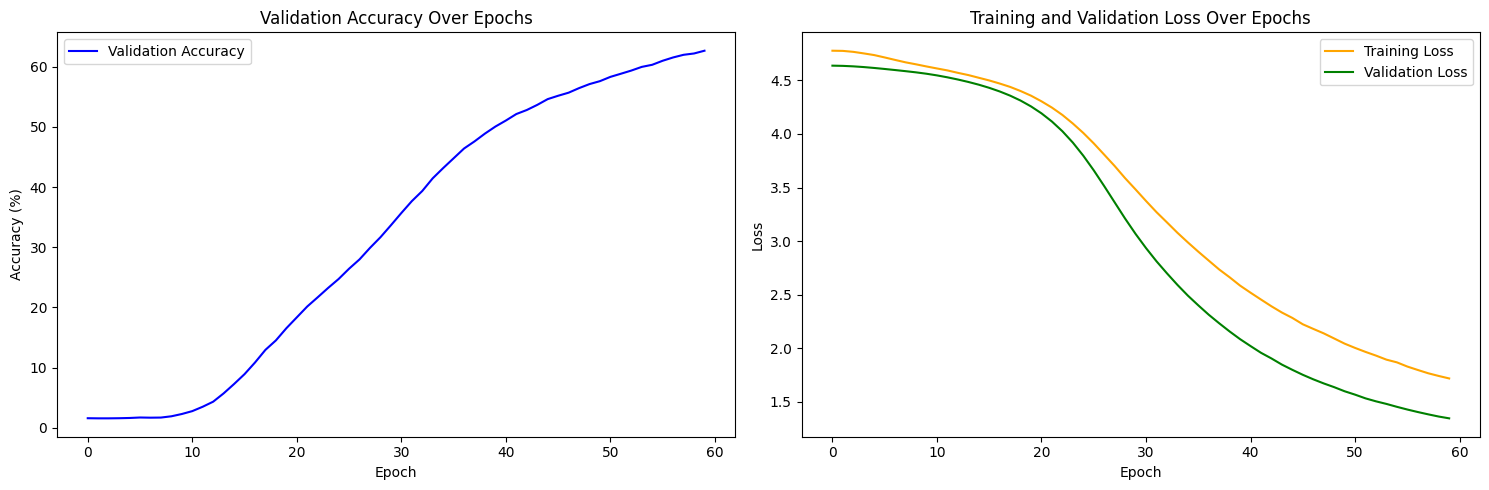

In [ ]:
metrics_C100_VGG16_RDrop = train_and_evaluate('CIFAR100', 'vgg16', True)
plot_results(metrics_C100_VGG16_RDrop)

Training VGG-16 on CIFAR-100 with R-Drop (alpha=0.9)


=== Training vgg16 on CIFAR100 with R-Drop = True ===
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-1-b02e3afd707b>:307: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [R-Drop Training] (CIFAR100, vgg16):   0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-1-b02e3afd707b>:235: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use 

Best model saved with accuracy: 1.57%
Epoch [1/60] Train Loss: 4.8146 Val Loss: 4.6379 Val Acc: 1.57% Time: 110.29s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Epoch [2/60] Train Loss: 4.8126 Val Loss: 4.6360 Val Acc: 1.55% Time: 106.63s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.66it/s]


Epoch [3/60] Train Loss: 4.8025 Val Loss: 4.6318 Val Acc: 1.56% Time: 106.80s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Epoch [4/60] Train Loss: 4.7859 Val Loss: 4.6255 Val Acc: 1.56% Time: 106.69s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.97it/s]


Best model saved with accuracy: 1.59%
Epoch [5/60] Train Loss: 4.7675 Val Loss: 4.6177 Val Acc: 1.59% Time: 108.13s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 1.61%
Epoch [6/60] Train Loss: 4.7422 Val Loss: 4.6091 Val Acc: 1.61% Time: 108.04s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.54it/s]


Best model saved with accuracy: 1.63%
Epoch [7/60] Train Loss: 4.7156 Val Loss: 4.5999 Val Acc: 1.63% Time: 108.00s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


Best model saved with accuracy: 1.65%
Epoch [8/60] Train Loss: 4.6905 Val Loss: 4.5907 Val Acc: 1.65% Time: 108.08s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.68it/s]


Best model saved with accuracy: 1.79%
Epoch [9/60] Train Loss: 4.6701 Val Loss: 4.5808 Val Acc: 1.79% Time: 108.04s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


Best model saved with accuracy: 1.99%
Epoch [10/60] Train Loss: 4.6496 Val Loss: 4.5693 Val Acc: 1.99% Time: 107.84s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.61it/s]


Best model saved with accuracy: 2.39%
Epoch [11/60] Train Loss: 4.6303 Val Loss: 4.5556 Val Acc: 2.39% Time: 107.96s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 25.00it/s]


Best model saved with accuracy: 3.04%
Epoch [12/60] Train Loss: 4.6123 Val Loss: 4.5397 Val Acc: 3.04% Time: 107.81s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


Best model saved with accuracy: 3.88%
Epoch [13/60] Train Loss: 4.5905 Val Loss: 4.5218 Val Acc: 3.88% Time: 108.21s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 4.97%
Epoch [14/60] Train Loss: 4.5710 Val Loss: 4.5022 Val Acc: 4.97% Time: 108.06s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.65it/s]


Best model saved with accuracy: 6.33%
Epoch [15/60] Train Loss: 4.5484 Val Loss: 4.4803 Val Acc: 6.33% Time: 107.98s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.89it/s]


Best model saved with accuracy: 8.10%
Epoch [16/60] Train Loss: 4.5267 Val Loss: 4.4550 Val Acc: 8.10% Time: 107.84s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


Best model saved with accuracy: 9.94%
Epoch [17/60] Train Loss: 4.5019 Val Loss: 4.4259 Val Acc: 9.94% Time: 107.94s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 11.90%
Epoch [18/60] Train Loss: 4.4751 Val Loss: 4.3923 Val Acc: 11.90% Time: 108.03s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 13.69%
Epoch [19/60] Train Loss: 4.4423 Val Loss: 4.3528 Val Acc: 13.69% Time: 108.04s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


Best model saved with accuracy: 15.45%
Epoch [20/60] Train Loss: 4.4056 Val Loss: 4.3060 Val Acc: 15.45% Time: 107.91s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 17.39%
Epoch [21/60] Train Loss: 4.3613 Val Loss: 4.2509 Val Acc: 17.39% Time: 107.96s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Best model saved with accuracy: 19.34%
Epoch [22/60] Train Loss: 4.3123 Val Loss: 4.1857 Val Acc: 19.34% Time: 107.80s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 21.04%
Epoch [23/60] Train Loss: 4.2543 Val Loss: 4.1081 Val Acc: 21.04% Time: 107.93s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 22.36%
Epoch [24/60] Train Loss: 4.1870 Val Loss: 4.0167 Val Acc: 22.36% Time: 108.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 23.74%
Epoch [25/60] Train Loss: 4.1117 Val Loss: 3.9103 Val Acc: 23.74% Time: 108.02s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 25.37%
Epoch [26/60] Train Loss: 4.0272 Val Loss: 3.7896 Val Acc: 25.37% Time: 107.95s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 26.90%
Epoch [27/60] Train Loss: 3.9338 Val Loss: 3.6557 Val Acc: 26.90% Time: 108.04s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 28.60%
Epoch [28/60] Train Loss: 3.8374 Val Loss: 3.5133 Val Acc: 28.60% Time: 108.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Best model saved with accuracy: 30.11%
Epoch [29/60] Train Loss: 3.7325 Val Loss: 3.3663 Val Acc: 30.11% Time: 108.03s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 31.75%
Epoch [30/60] Train Loss: 3.6328 Val Loss: 3.2233 Val Acc: 31.75% Time: 108.00s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Best model saved with accuracy: 33.90%
Epoch [31/60] Train Loss: 3.5296 Val Loss: 3.0881 Val Acc: 33.90% Time: 108.00s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 36.05%
Epoch [32/60] Train Loss: 3.4288 Val Loss: 2.9617 Val Acc: 36.05% Time: 108.07s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Best model saved with accuracy: 37.86%
Epoch [33/60] Train Loss: 3.3344 Val Loss: 2.8455 Val Acc: 37.86% Time: 108.03s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.70it/s]


Best model saved with accuracy: 39.61%
Epoch [34/60] Train Loss: 3.2390 Val Loss: 2.7338 Val Acc: 39.61% Time: 108.11s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.91it/s]


Best model saved with accuracy: 41.38%
Epoch [35/60] Train Loss: 3.1484 Val Loss: 2.6276 Val Acc: 41.38% Time: 108.06s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.56it/s]


Best model saved with accuracy: 42.91%
Epoch [36/60] Train Loss: 3.0611 Val Loss: 2.5328 Val Acc: 42.91% Time: 108.09s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 44.43%
Epoch [37/60] Train Loss: 2.9768 Val Loss: 2.4397 Val Acc: 44.43% Time: 108.15s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Best model saved with accuracy: 45.95%
Epoch [38/60] Train Loss: 2.8924 Val Loss: 2.3545 Val Acc: 45.95% Time: 108.16s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 47.49%
Epoch [39/60] Train Loss: 2.8168 Val Loss: 2.2752 Val Acc: 47.49% Time: 108.12s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 48.68%
Epoch [40/60] Train Loss: 2.7380 Val Loss: 2.1976 Val Acc: 48.68% Time: 107.93s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 49.78%
Epoch [41/60] Train Loss: 2.6696 Val Loss: 2.1284 Val Acc: 49.78% Time: 108.11s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.89it/s]


Best model saved with accuracy: 50.83%
Epoch [42/60] Train Loss: 2.6026 Val Loss: 2.0606 Val Acc: 50.83% Time: 107.97s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 51.57%
Epoch [43/60] Train Loss: 2.5372 Val Loss: 2.0035 Val Acc: 51.57% Time: 108.19s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 52.54%
Epoch [44/60] Train Loss: 2.4759 Val Loss: 1.9428 Val Acc: 52.54% Time: 107.98s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


Best model saved with accuracy: 53.43%
Epoch [45/60] Train Loss: 2.4229 Val Loss: 1.8896 Val Acc: 53.43% Time: 108.15s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Best model saved with accuracy: 54.10%
Epoch [46/60] Train Loss: 2.3614 Val Loss: 1.8379 Val Acc: 54.10% Time: 108.18s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.68it/s]


Best model saved with accuracy: 54.84%
Epoch [47/60] Train Loss: 2.3160 Val Loss: 1.7936 Val Acc: 54.84% Time: 108.21s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.91it/s]


Best model saved with accuracy: 55.55%
Epoch [48/60] Train Loss: 2.2705 Val Loss: 1.7507 Val Acc: 55.55% Time: 108.03s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.78it/s]


Best model saved with accuracy: 56.16%
Epoch [49/60] Train Loss: 2.2198 Val Loss: 1.7125 Val Acc: 56.16% Time: 108.07s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 56.77%
Epoch [50/60] Train Loss: 2.1697 Val Loss: 1.6703 Val Acc: 56.77% Time: 108.27s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


Best model saved with accuracy: 57.53%
Epoch [51/60] Train Loss: 2.1276 Val Loss: 1.6358 Val Acc: 57.53% Time: 108.12s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 58.19%
Epoch [52/60] Train Loss: 2.0876 Val Loss: 1.5989 Val Acc: 58.19% Time: 108.20s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.66it/s]


Best model saved with accuracy: 58.74%
Epoch [53/60] Train Loss: 2.0495 Val Loss: 1.5660 Val Acc: 58.74% Time: 107.82s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 59.16%
Epoch [54/60] Train Loss: 2.0099 Val Loss: 1.5402 Val Acc: 59.16% Time: 107.93s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.67it/s]


Best model saved with accuracy: 59.78%
Epoch [55/60] Train Loss: 1.9821 Val Loss: 1.5116 Val Acc: 59.78% Time: 108.15s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Best model saved with accuracy: 60.32%
Epoch [56/60] Train Loss: 1.9404 Val Loss: 1.4833 Val Acc: 60.32% Time: 108.11s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.94it/s]


Best model saved with accuracy: 60.65%
Epoch [57/60] Train Loss: 1.9063 Val Loss: 1.4578 Val Acc: 60.65% Time: 107.76s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.74it/s]


Best model saved with accuracy: 61.22%
Epoch [58/60] Train Loss: 1.8735 Val Loss: 1.4326 Val Acc: 61.22% Time: 108.07s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.70it/s]


Best model saved with accuracy: 61.54%
Epoch [59/60] Train Loss: 1.8464 Val Loss: 1.4106 Val Acc: 61.54% Time: 107.95s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.93it/s]


Best model saved with accuracy: 62.06%
Epoch [60/60] Train Loss: 1.8206 Val Loss: 1.3927 Val Acc: 62.06% Time: 107.99s
Training completed for vgg16 on CIFAR100 with R-Drop = True
Best Validation Accuracy: 62.06%



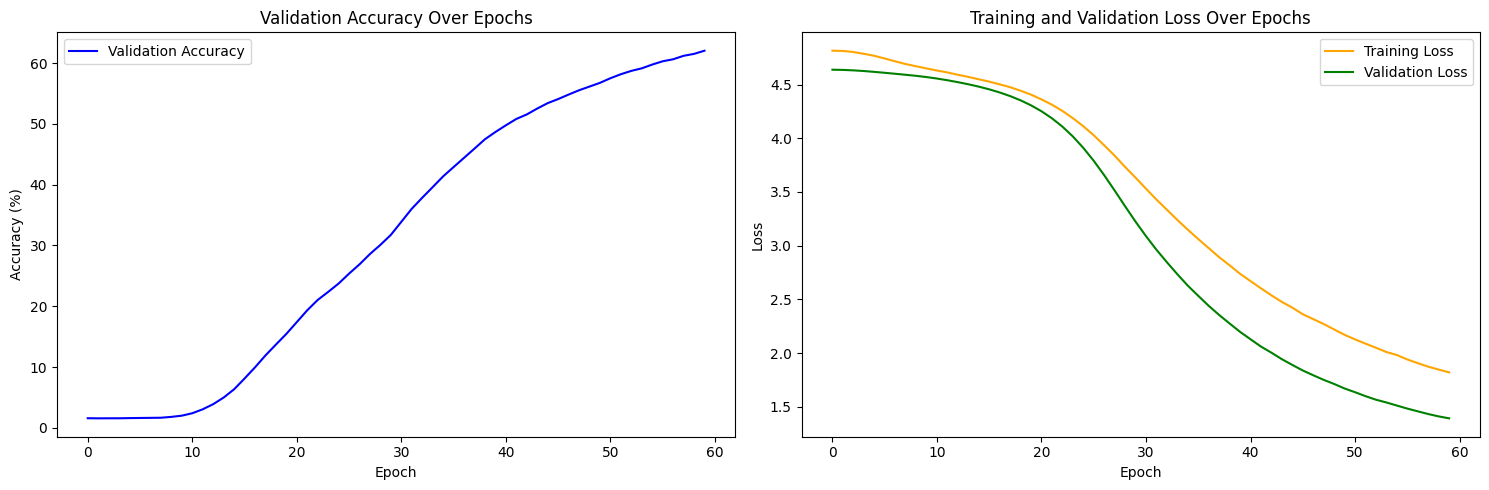

In [ ]:
metrics_C100_VGG16_RDrop_09 = train_and_evaluate('CIFAR100', 'vgg16', True)
plot_results(metrics_C100_VGG16_RDrop_09)

Training VGG-16 on CIFAR-100


=== Training vgg16 on CIFAR100 with R-Drop = False ===


100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


Extracting ./data/CIFAR100/cifar-100-python.tar.gz to ./data/CIFAR100
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 160MB/s]
<ipython-input-1-b02e3afd707b>:307: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1 [Standard T

Best model saved with accuracy: 1.57%
Epoch [1/60] Train Loss: 4.7052 Val Loss: 4.6379 Val Acc: 1.57% Time: 62.35s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.90it/s]


Epoch [2/60] Train Loss: 4.7007 Val Loss: 4.6357 Val Acc: 1.55% Time: 58.61s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.95it/s]


Epoch [3/60] Train Loss: 4.6975 Val Loss: 4.6308 Val Acc: 1.56% Time: 58.65s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


Best model saved with accuracy: 1.63%
Epoch [4/60] Train Loss: 4.6852 Val Loss: 4.6235 Val Acc: 1.63% Time: 59.71s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.96it/s]


Best model saved with accuracy: 1.68%
Epoch [5/60] Train Loss: 4.6748 Val Loss: 4.6141 Val Acc: 1.68% Time: 59.95s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 1.81%
Epoch [6/60] Train Loss: 4.6583 Val Loss: 4.6030 Val Acc: 1.81% Time: 60.21s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 1.91%
Epoch [7/60] Train Loss: 4.6429 Val Loss: 4.5908 Val Acc: 1.91% Time: 59.95s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 2.08%
Epoch [8/60] Train Loss: 4.6254 Val Loss: 4.5775 Val Acc: 2.08% Time: 60.06s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.72it/s]


Best model saved with accuracy: 2.23%
Epoch [9/60] Train Loss: 4.6083 Val Loss: 4.5632 Val Acc: 2.23% Time: 60.20s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


Best model saved with accuracy: 2.64%
Epoch [10/60] Train Loss: 4.5878 Val Loss: 4.5474 Val Acc: 2.64% Time: 59.99s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 25.04it/s]


Best model saved with accuracy: 3.25%
Epoch [11/60] Train Loss: 4.5732 Val Loss: 4.5289 Val Acc: 3.25% Time: 59.97s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.97it/s]


Best model saved with accuracy: 4.02%
Epoch [12/60] Train Loss: 4.5496 Val Loss: 4.5075 Val Acc: 4.02% Time: 60.09s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


Best model saved with accuracy: 5.15%
Epoch [13/60] Train Loss: 4.5268 Val Loss: 4.4832 Val Acc: 5.15% Time: 59.78s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 6.37%
Epoch [14/60] Train Loss: 4.5032 Val Loss: 4.4561 Val Acc: 6.37% Time: 59.71s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.95it/s]


Best model saved with accuracy: 7.83%
Epoch [15/60] Train Loss: 4.4722 Val Loss: 4.4252 Val Acc: 7.83% Time: 60.12s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.74it/s]


Best model saved with accuracy: 9.64%
Epoch [16/60] Train Loss: 4.4414 Val Loss: 4.3898 Val Acc: 9.64% Time: 59.97s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 11.50%
Epoch [17/60] Train Loss: 4.4047 Val Loss: 4.3484 Val Acc: 11.50% Time: 60.06s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 13.23%
Epoch [18/60] Train Loss: 4.3596 Val Loss: 4.2998 Val Acc: 13.23% Time: 60.10s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 15.04%
Epoch [19/60] Train Loss: 4.3078 Val Loss: 4.2424 Val Acc: 15.04% Time: 60.14s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 16.97%
Epoch [20/60] Train Loss: 4.2486 Val Loss: 4.1741 Val Acc: 16.97% Time: 60.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.94it/s]


Best model saved with accuracy: 18.90%
Epoch [21/60] Train Loss: 4.1814 Val Loss: 4.0929 Val Acc: 18.90% Time: 60.13s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.96it/s]


Best model saved with accuracy: 20.59%
Epoch [22/60] Train Loss: 4.0963 Val Loss: 3.9967 Val Acc: 20.59% Time: 60.23s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 22.15%
Epoch [23/60] Train Loss: 4.0119 Val Loss: 3.8839 Val Acc: 22.15% Time: 59.61s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


Best model saved with accuracy: 23.76%
Epoch [24/60] Train Loss: 3.9041 Val Loss: 3.7533 Val Acc: 23.76% Time: 59.97s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.62it/s]


Best model saved with accuracy: 25.32%
Epoch [25/60] Train Loss: 3.7837 Val Loss: 3.6050 Val Acc: 25.32% Time: 60.23s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


Best model saved with accuracy: 27.09%
Epoch [26/60] Train Loss: 3.6585 Val Loss: 3.4440 Val Acc: 27.09% Time: 60.18s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


Best model saved with accuracy: 28.99%
Epoch [27/60] Train Loss: 3.5367 Val Loss: 3.2785 Val Acc: 28.99% Time: 59.97s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


Best model saved with accuracy: 30.94%
Epoch [28/60] Train Loss: 3.4145 Val Loss: 3.1171 Val Acc: 30.94% Time: 60.09s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Best model saved with accuracy: 32.91%
Epoch [29/60] Train Loss: 3.2860 Val Loss: 2.9634 Val Acc: 32.91% Time: 60.12s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 35.13%
Epoch [30/60] Train Loss: 3.1692 Val Loss: 2.8266 Val Acc: 35.13% Time: 60.27s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 25.06it/s]


Best model saved with accuracy: 37.12%
Epoch [31/60] Train Loss: 3.0630 Val Loss: 2.7077 Val Acc: 37.12% Time: 60.11s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 39.21%
Epoch [32/60] Train Loss: 2.9642 Val Loss: 2.5922 Val Acc: 39.21% Time: 59.86s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


Best model saved with accuracy: 41.01%
Epoch [33/60] Train Loss: 2.8607 Val Loss: 2.4890 Val Acc: 41.01% Time: 60.06s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 42.82%
Epoch [34/60] Train Loss: 2.7686 Val Loss: 2.3926 Val Acc: 42.82% Time: 60.05s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.97it/s]


Best model saved with accuracy: 44.26%
Epoch [35/60] Train Loss: 2.6815 Val Loss: 2.3091 Val Acc: 44.26% Time: 60.11s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.89it/s]


Best model saved with accuracy: 45.82%
Epoch [36/60] Train Loss: 2.5989 Val Loss: 2.2249 Val Acc: 45.82% Time: 60.15s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 47.32%
Epoch [37/60] Train Loss: 2.5269 Val Loss: 2.1489 Val Acc: 47.32% Time: 60.11s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Best model saved with accuracy: 48.31%
Epoch [38/60] Train Loss: 2.4497 Val Loss: 2.0853 Val Acc: 48.31% Time: 60.13s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.70it/s]


Best model saved with accuracy: 49.62%
Epoch [39/60] Train Loss: 2.3741 Val Loss: 2.0124 Val Acc: 49.62% Time: 59.99s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.85it/s]


Best model saved with accuracy: 50.44%
Epoch [40/60] Train Loss: 2.3212 Val Loss: 1.9600 Val Acc: 50.44% Time: 60.08s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.82it/s]


Best model saved with accuracy: 51.53%
Epoch [41/60] Train Loss: 2.2654 Val Loss: 1.9071 Val Acc: 51.53% Time: 59.82s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.74it/s]


Best model saved with accuracy: 52.64%
Epoch [42/60] Train Loss: 2.2098 Val Loss: 1.8534 Val Acc: 52.64% Time: 60.12s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Best model saved with accuracy: 53.27%
Epoch [43/60] Train Loss: 2.1555 Val Loss: 1.8079 Val Acc: 53.27% Time: 60.24s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.93it/s]


Best model saved with accuracy: 54.10%
Epoch [44/60] Train Loss: 2.1034 Val Loss: 1.7601 Val Acc: 54.10% Time: 60.16s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Best model saved with accuracy: 54.67%
Epoch [45/60] Train Loss: 2.0577 Val Loss: 1.7176 Val Acc: 54.67% Time: 59.90s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.82it/s]


Best model saved with accuracy: 55.52%
Epoch [46/60] Train Loss: 2.0161 Val Loss: 1.6805 Val Acc: 55.52% Time: 60.09s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 56.03%
Epoch [47/60] Train Loss: 1.9693 Val Loss: 1.6477 Val Acc: 56.03% Time: 60.13s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


Best model saved with accuracy: 56.83%
Epoch [48/60] Train Loss: 1.9289 Val Loss: 1.6110 Val Acc: 56.83% Time: 60.02s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 57.22%
Epoch [49/60] Train Loss: 1.8875 Val Loss: 1.5813 Val Acc: 57.22% Time: 60.08s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.89it/s]


Best model saved with accuracy: 57.78%
Epoch [50/60] Train Loss: 1.8555 Val Loss: 1.5507 Val Acc: 57.78% Time: 59.89s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Best model saved with accuracy: 58.17%
Epoch [51/60] Train Loss: 1.8185 Val Loss: 1.5201 Val Acc: 58.17% Time: 60.01s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.90it/s]


Best model saved with accuracy: 58.92%
Epoch [52/60] Train Loss: 1.7884 Val Loss: 1.4972 Val Acc: 58.92% Time: 59.94s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Best model saved with accuracy: 59.28%
Epoch [53/60] Train Loss: 1.7541 Val Loss: 1.4674 Val Acc: 59.28% Time: 60.12s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


Best model saved with accuracy: 59.77%
Epoch [54/60] Train Loss: 1.7276 Val Loss: 1.4469 Val Acc: 59.77% Time: 60.15s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


Best model saved with accuracy: 60.52%
Epoch [55/60] Train Loss: 1.7018 Val Loss: 1.4223 Val Acc: 60.52% Time: 60.03s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]


Best model saved with accuracy: 60.76%
Epoch [56/60] Train Loss: 1.6683 Val Loss: 1.4010 Val Acc: 60.76% Time: 60.18s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 25.04it/s]


Best model saved with accuracy: 61.06%
Epoch [57/60] Train Loss: 1.6393 Val Loss: 1.3807 Val Acc: 61.06% Time: 60.02s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.99it/s]


Best model saved with accuracy: 61.40%
Epoch [58/60] Train Loss: 1.6233 Val Loss: 1.3628 Val Acc: 61.40% Time: 61.17s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


Best model saved with accuracy: 61.92%
Epoch [59/60] Train Loss: 1.5873 Val Loss: 1.3446 Val Acc: 61.92% Time: 59.73s


Evaluating (CIFAR100, vgg16): 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Best model saved with accuracy: 62.55%
Epoch [60/60] Train Loss: 1.5739 Val Loss: 1.3269 Val Acc: 62.55% Time: 60.19s
Training completed for vgg16 on CIFAR100 with R-Drop = False
Best Validation Accuracy: 62.55%



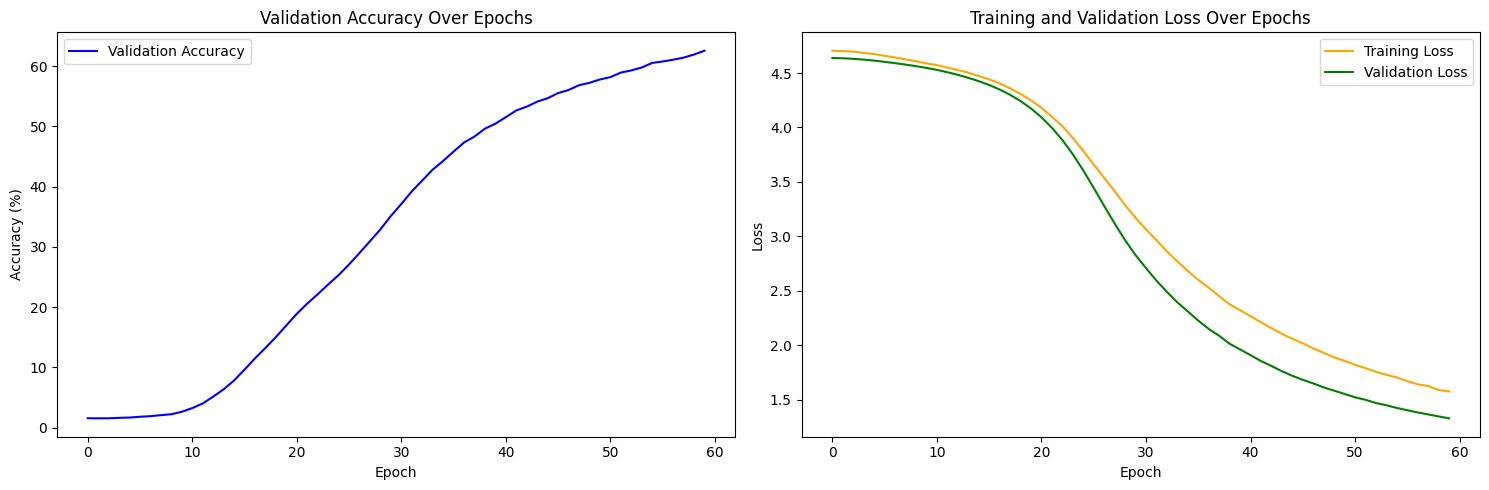

In [ ]:
metrics_C100_VGG16 = train_and_evaluate('CIFAR100', 'vgg16', False)
plot_results(metrics_C100_VGG16)

Training ResNet-50 on CIFAR-10 with R-Drop

In [ ]:
# metrics_C10_ResNet50_RDrop = train_and_evaluate('CIFAR10', 'resnet50', True)
# plot_results(metrics_C10_ResNet50_RDrop)

Training ResNet-50 on CIFAR-10

In [ ]:
# metrics_C10_ResNet50 = train_and_evaluate('CIFAR10', 'resnet50', False)
# plot_results(metrics_C10_ResNet50)